# Modeltraining

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..") / "02_src"))

In [2]:
# ----------------------------------
# IMPORTS
#-----------------------------------

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GroupKFold, StratifiedGroupKFold, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer, OneHotEncoder, FunctionTransformer, QuantileTransformer, PolynomialFeatures

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, mean_pinball_loss, make_scorer
import scipy.stats as stats

from sklearn.decomposition import PCA

from sklearn.inspection import permutation_importance

from sklearn import set_config
#set_config(transform_output="pandas")

In [3]:
# get main, clean prepared df 
from config import data_preparation
df = data_preparation()

Load and merge raw datasets, reduce dataset to limited year-periods per country...
Exclude countries with high missing values rate (> 50%)...
Start ML process for prepared df with 1158 rows...
Load and merge raw datasets, reduce dataset to limited year-periods per country...
Exclude countries with high missing values rate (> 50%)...
Start ML process for prepared df with 1158 rows...


### Helper Visualization Functions

In [4]:
# ----------------------------------
# RESIDUAL PLOT
#-----------------------------------
def residual_plot(y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    sns.residplot(x=y_predicts, y=residuals, lowess=True, line_kws=dict(color="r"))
    plt.title(f"Residual-Plot for {model}")
    plt.xlabel("Predictions")
    plt.ylabel("Residuals (y_train - y_predicted)")
    plt.show()

def residuals_hist(residuals, model):
    plt.figure(figsize=(10,4))
    sns.histplot(residuals)
    plt.title(f"Resiudals Histogram for {model}")
    plt.show()

In [5]:
# -----------------------------------
# SCATTERPLOT PREDICTED VS REAL
#------------------------------------
def actual_vs_predicted(y_true, y_predicts, residuals, model):
    plt.figure(figsize=(10,4))
    ax = sns.scatterplot(x=y_true, y=y_predicts, hue=residuals)
    
    #plt.axline((0,0), slope=1) #https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
    #ax.set_xlim(-10, y_true.max())
    #ax.set_ylim(-10, y_true.max())
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
    
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

# Q-Q Plot
def prob_plot(residuals):
    plt.figure(figsize=(10, 5))
    stats.probplot(residuals, plot=plt)
    plt.show()

In [6]:
# -----------------------------------
# METRIC SCORES FOR CV
#------------------------------------
def show_scores(grid, model):
    best_score = grid.best_score_ 
    best_idx = grid.best_index_
    cv_res = pd.DataFrame(grid.cv_results_)
    folds_num = 4

    best_estimator = pd.DataFrame(cv_res.loc[cv_res["mean_test_r2"] == best_score]).reset_index()
    
    print(f"\n------{model} CV SCORES--------")  
    print("\nR2:")
    print(f'''\nTrain Folds R2 Scores: {[round(cv_res[f"split{i}_train_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train R2 Score: {round(cv_res["mean_train_r2"][best_idx], 2)}
            \nTest Folds R2 Scores: {[round(cv_res[f"split{i}_test_r2"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test R2 Score (best_score_): {round(cv_res["mean_test_r2"][best_idx], 2)})   
            \nStd Test R2 Score: {round(cv_res["std_test_r2"][best_idx], 2)}''') 
    print("\nMAE:")
    #print(f'MAE error in relation to mean target: {-round( (cv_res["mean_test_mae"][best_idx] / target_mean()) * 100, 2 )} %')
    print(f'''\nTrain Folds MAE Scores: {[-round(cv_res[f"split{i}_train_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train MAE Score: {-round(cv_res["mean_train_mae"][best_idx],2)}
            \nTest Folds MAE Scores: {[-round(cv_res[f"split{i}_test_mae"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test MAE Score: {-round(cv_res["mean_test_mae"][best_idx],2)}
            \nStd Test MAE Score: {round(cv_res["std_test_mae"][best_idx], 2)}''') 
    print("\nRMSE:")
    print(f'''\nTrain Folds RMSE Scores: {[-round(cv_res[f"split{i}_train_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Train RMSE Score: {-round(cv_res["mean_train_rmse"][best_idx], 2)}
            \nTest Folds RMSE Scores: {[-round(cv_res[f"split{i}_test_rmse"][best_idx], 2) for i in range(folds_num)]}
            \nMean Test RMSE Score: {-round(cv_res["mean_test_rmse"][best_idx], 2)}
            \nStd Test MAE Score: {round(cv_res["std_test_rmse"][best_idx], 2)}''')
    print("-----------------------------------------\n")

metrics = {"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}

In [7]:
# -----------------------------------
# METRIC SCORES FOR HOLDOUT TESTSET
#------------------------------------
def holdout_test(model, Xtest):
    y_pred = model.predict(Xtest)
    MAE_test = mean_absolute_error(y_test, y_pred)
    R2_test  = r2_score(y_test, y_pred)
    RMSE_test = root_mean_squared_error(y_test, y_pred)
    print(f"----Holdout Testset: Final Metric Scores----\n MAE: {MAE_test}, R2: {R2_test}, RMSE: {RMSE_test}")  
    
    errors = np.abs(y_test - y_pred)
    print(np.percentile(errors, [50, 75, 90, 95]))         

### Variables & Train-Test Split

In [128]:
# ----------------------------------
# VARIABLES: Features, Target, Group
#-----------------------------------

y = df["child_mortality_igme"] #target
X = df.drop(columns=["Code", "Year", "child_mortality_igme"]) #features
group = df["Entity"]

num_variables = X.drop(columns=["Entity", "world_regions_wb", "world_income_group"]).columns.to_list()
cat_variables = ["world_regions_wb", "world_income_group"]
regions_list = sorted(X["world_regions_wb"].dropna().unique())
incomegroups_list = sorted(X["world_income_group"].dropna().unique())

normal = ["years_of_schooling", "share_of_population_urban"] #normal distributed
others = ["vaccination_coverage_who_unicef"] #leftskewed
remove_nonskewed = normal + others

skewed_variables = num_variables.copy() #rightskewed vars
for el in remove_nonskewed:
    if el in skewed_variables:
        skewed_variables.remove(el)

world_regions = ["world_regions_wb"]
income_groups = ["world_income_group"]

#helper column names
col_country = "Entity"             
col_regions = "world_regions_wb"  
col_incomegroup = "world_income_group"
all_numeric_cols = skewed_variables + others + normal

col_healthspending = "annual_healthcare_expenditure_per_capita"
col_gdp = "gdp_per_capita_worldbank"
health_gdp =[] 

#all_numeric_cols

rest_nums = ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people", "prevalence_of_undernourishment", "share_without_improved_water",
              "vaccination_coverage_who_unicef", "years_of_schooling", "share_of_population_urban"]

In [129]:
# ----------------------------------
# Train/Test Split
#-----------------------------------

gs_split = GroupShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=99)
train_index, test_index = next(gs_split.split(X, y, group))

X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]
group_train = group.iloc[train_index]
group_test  = group.iloc[test_index]

#### Diagrams & Residuals by Regions/Groups

In [194]:
#Actual vs Predicted by Region
def actual_vs_predicted_regions(X, y_true, y_predicts, residuals, group, model):
    df_preds_region = pd.DataFrame({
        "actual": y_true,
        "predicted": y_predicts,
        "group": X[group]
    })
    #df_preds_region["residual"] = abs(df_preds_region["actual"] - df_preds_region["predicted"])
    plt.figure(figsize=(12,4))
    ax = sns.scatterplot(data=df_preds_region, x="actual", y="predicted", hue="group", alpha=0.7)
    sns.move_legend(ax, "upper right")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()])
    plt.title(f"Predicted vs Real Target for {model}")
    plt.ylabel("Predicted Target")
    plt.xlabel("Real Target")
    plt.show()

#Boxplots by Region
def boxplots_residuals(X, y_true, y_predicts, residuals, group, model):
    df_preds_region = pd.DataFrame({
        "actual": y_true,
        "predicted": y_predicts,
        "group": X[group]
    })
    plt.figure(figsize=(12,4))
    df_preds_region["error"] = residuals #abs(df_preds_region['Actual'] - df_preds_region['Predicted'])
    plt.title(f"Residuals Boxplots {model}")
    sns.boxplot(data=df_preds_region, x="error", y="group")
    plt.show()

#Residual Plot by Region
def residual_plot_regions(X, y_true, y_predicts, residuals, group, model):
    df_preds_region = pd.DataFrame({
        "actual": y_true,
        "predicted": y_predicts,
        "group": X[group]
    })
    df_preds_region["residuals"] = df_preds_region["actual"] - df_preds_region["predicted"]

    plt.figure(figsize=(12,4))
    #sns.lmplot(data=df_preds_region, x='Actual', y='Predicted', hue='Region', height=5, aspect=1.2, legend=False, scatter_kws={'alpha':0.5})
    sns.scatterplot(data=df_preds_region, x="predicted", y="residuals", hue="group", alpha=0.7)
    plt.axhline(0, color='red', linestyle='--')
    #sns.relplot(data=df_preds_region, x='Predicted', y='Residuals', col='Region', col_wrap=3, kind='scatter', alpha=0.7)
    #for ax in plt.gcf().axes:
    #    ax.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals for {model}")
    plt.show()

def residuals_sorted(X, y_true, y_predicts, residuals, group):
    df_residuals_by_region = pd.DataFrame({
    "actual": y_true,
    "predicted": y_predicts,
    "residuals": residuals,
    "group": X[group]
    })
    return df_residuals_by_region.sort_values(by=["residuals"], ascending=False)

def metrics_per_group(X, y_true, y_pred, group):
    groups = X[group].unique()
    print(f"\nMetrics comparison between {group}:\n")
    for g in groups:
        mask = X[group] == g
        group_rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        group_mae = mean_absolute_error(y_true[mask], y_pred[mask])
        print(f"{g} RMSE: {group_rmse:.4f}")
        print(f"{g} MAE: {group_mae:.4f}")

### Kmeans Cluster Analysis

In [18]:
#How are countries clustered?
#X_train_cluster = X_train[num_variables].copy()
X_train_cluster = X[num_variables].copy()

kmeans_rscaler = RobustScaler().fit(X_train_cluster)
X_kmeans_scaled = kmeans_rscaler.transform(X_train_cluster)

knn_impute = KNNImputer(n_neighbors=5, weights="distance")
X_kmeans_imputed = knn_impute.fit_transform(X_kmeans_scaled)

km_train = KMeans(n_clusters=4, random_state=99)
km_train.fit(X_kmeans_imputed)

km_dist_train = km_train.transform(X_kmeans_imputed)

knn_imputed = kmeans_rscaler.inverse_transform(X_kmeans_imputed)
df_knn_imputed = pd.DataFrame(knn_imputed, columns=X_train_cluster.columns, index=X_train_cluster.index)

km_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_train.shape[1])]
X_cl = df_knn_imputed.copy()
X_cl[km_distcols] = km_dist_train

clusters_df = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl.index)
#kmeans_cluster_columns = pd.concat([km_dist_train], axis=1)
#kmeans_cluster_cols = pd.DataFrame(km_dist_train, columns=km_distcols, index=X_cl_train.copy().index)

In [19]:
X_cl["Entity"] = X["Entity"]
X_cl["world_regions_wb"] = X["world_regions_wb"]
X_cl["world_income_group"] = X["world_income_group"]

In [20]:
distcols = ["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3"]
X_cl["assigned_cluster"] = X_cl[distcols].idxmin(axis=1)

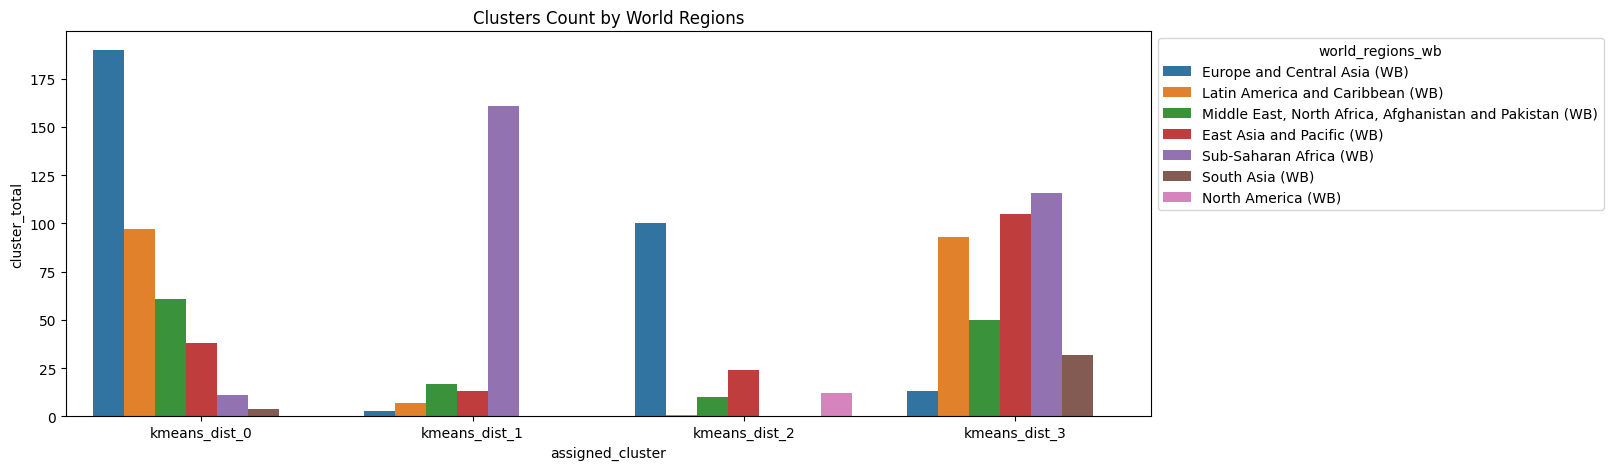

In [21]:
X_cl["assigned_cluster"].value_counts()
counts_cluster = X_cl.groupby("assigned_cluster")[["world_regions_wb"]].value_counts().reset_index(name="cluster_total")

plt.figure(figsize=(14, 5))
ax = sns.barplot(data=counts_cluster, x='assigned_cluster', y='cluster_total', hue='world_regions_wb')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Clusters Count by World Regions")
plt.show()

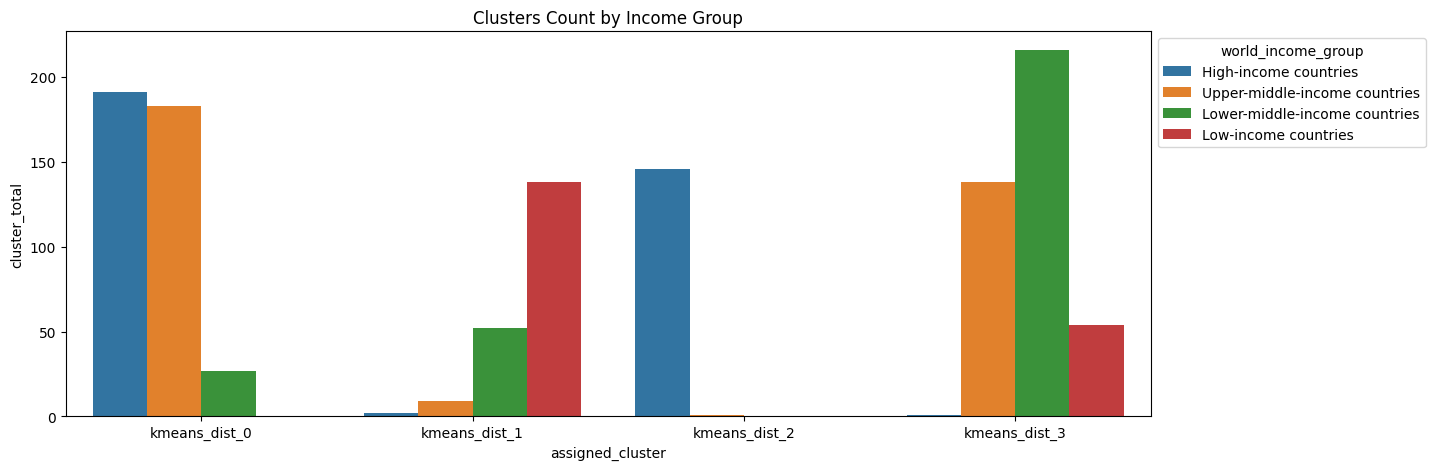

In [22]:
counts_cluster_ig = X_cl.groupby("assigned_cluster")[["world_income_group"]].value_counts().reset_index(name="cluster_total")
plt.figure(figsize=(14, 5))
ax = sns.barplot(data=counts_cluster_ig, x='assigned_cluster', y='cluster_total', hue='world_income_group')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Clusters Count by Income Group")
plt.show()

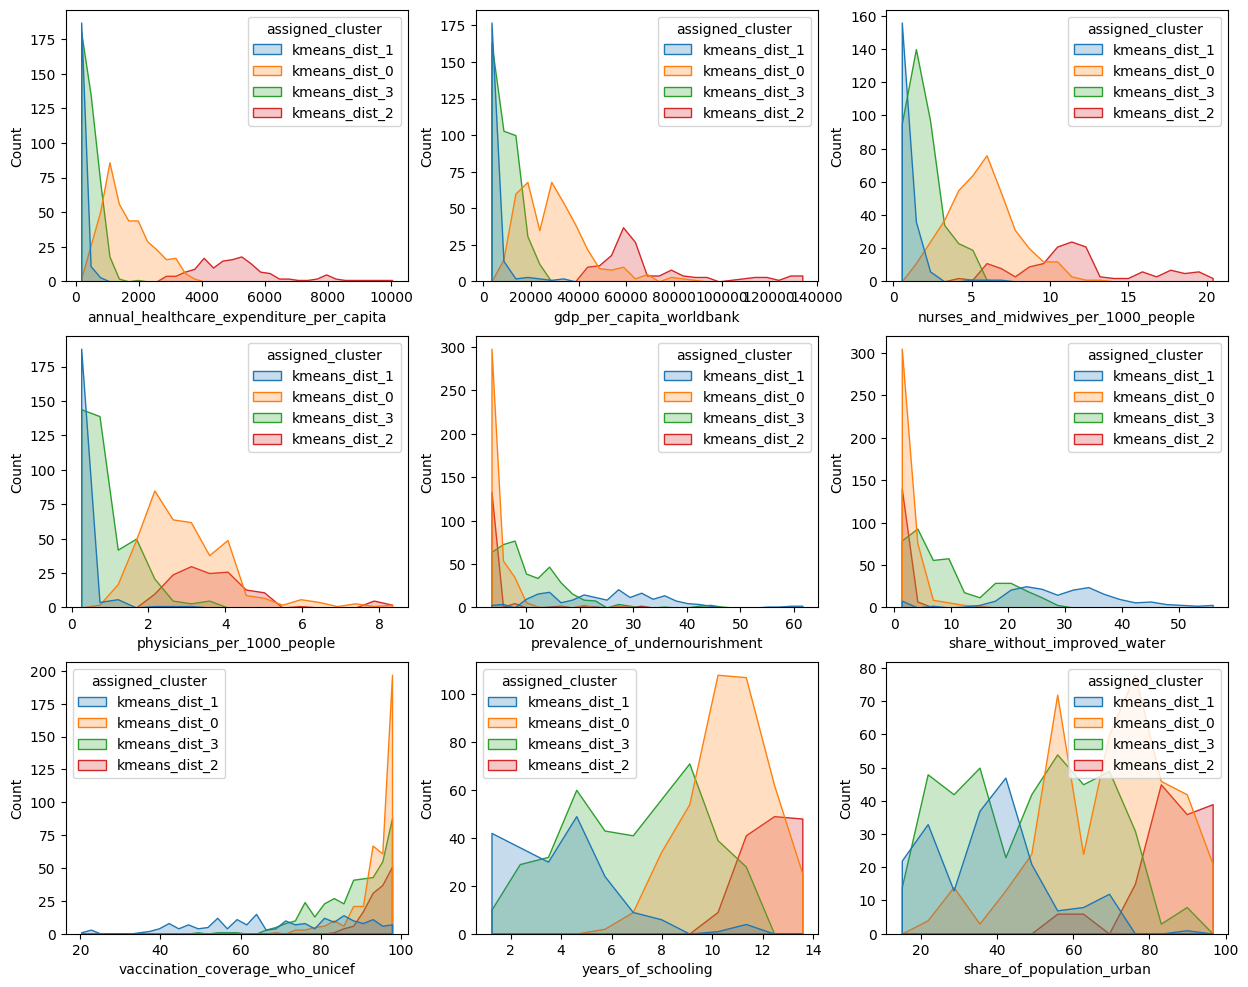

In [106]:
#Features Dist by cluster
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for idx, num_col in enumerate(all_numeric_cols):
    ax = axes[idx]
    sns.histplot(data=X_cl, element="poly", x=num_col, hue="assigned_cluster", fill=True, ax=ax)
plt.show()

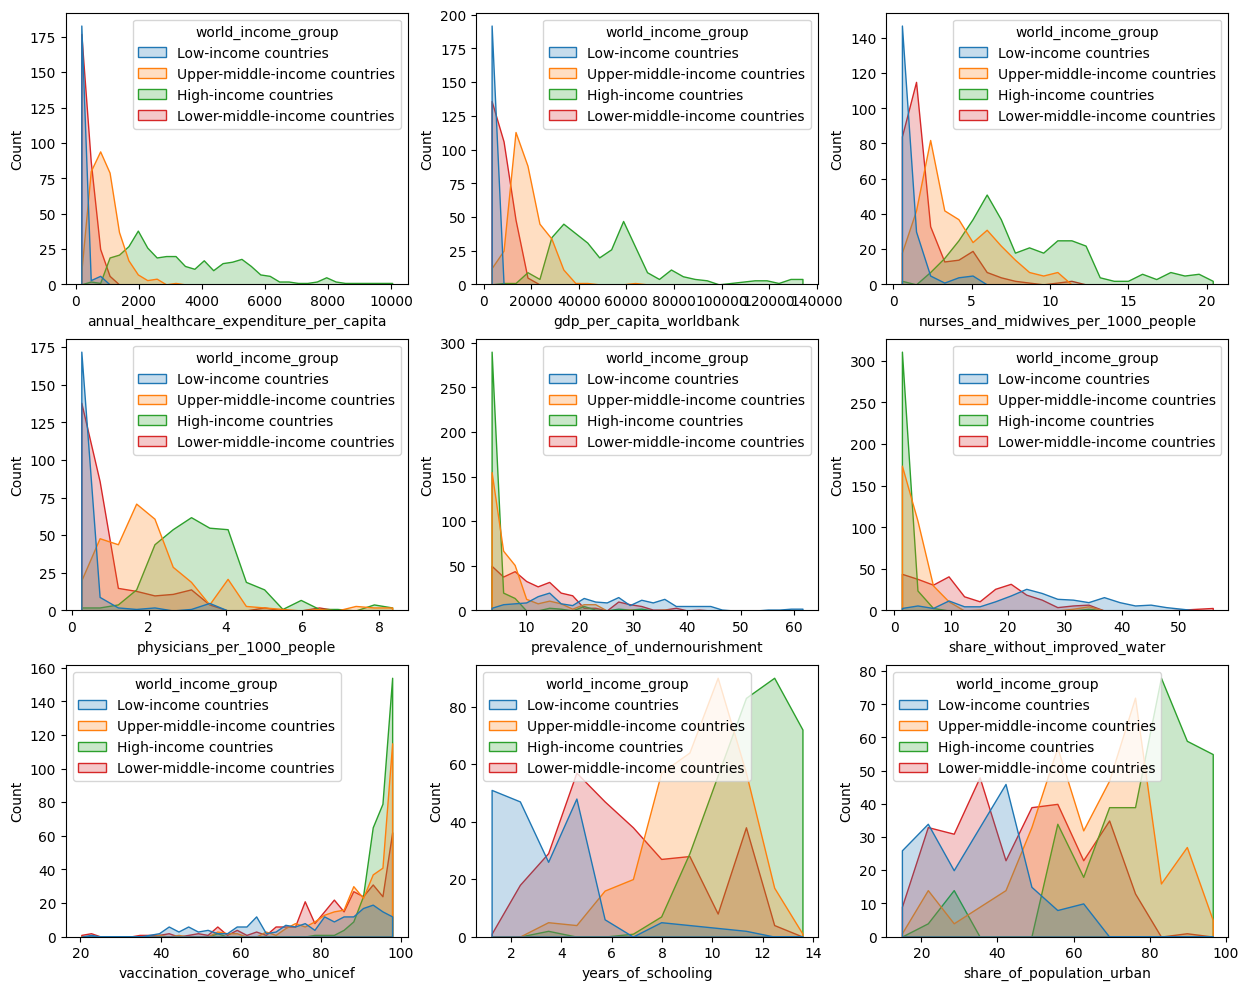

In [110]:
#Features Dist by income group
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()
for idx, num_col in enumerate(all_numeric_cols):
    ax = axes[idx]
    sns.histplot(data=X_cl, element="poly", x=num_col, hue="world_income_group", fill=True, ax=ax)
plt.show()

In [16]:
#Kmeans on Testset
X_holdout_testset = X_test[num_variables].copy()

X_test_df = X_holdout_testset.copy()
X_test_df_scaled = kmeans_rscaler.transform(X_test_df)  
X_test_df_imputed = knn_impute.transform(X_test_df_scaled)  
km_dist_test = km_train.transform(X_test_df_imputed)

km_test_distcols = [f"kmeans_dist_{i}" for i in range(km_dist_test.shape[1])]
X_cl_test = X_test.copy()
X_cl_test[km_test_distcols] = km_dist_test

#### Visualize Cluster with PCA

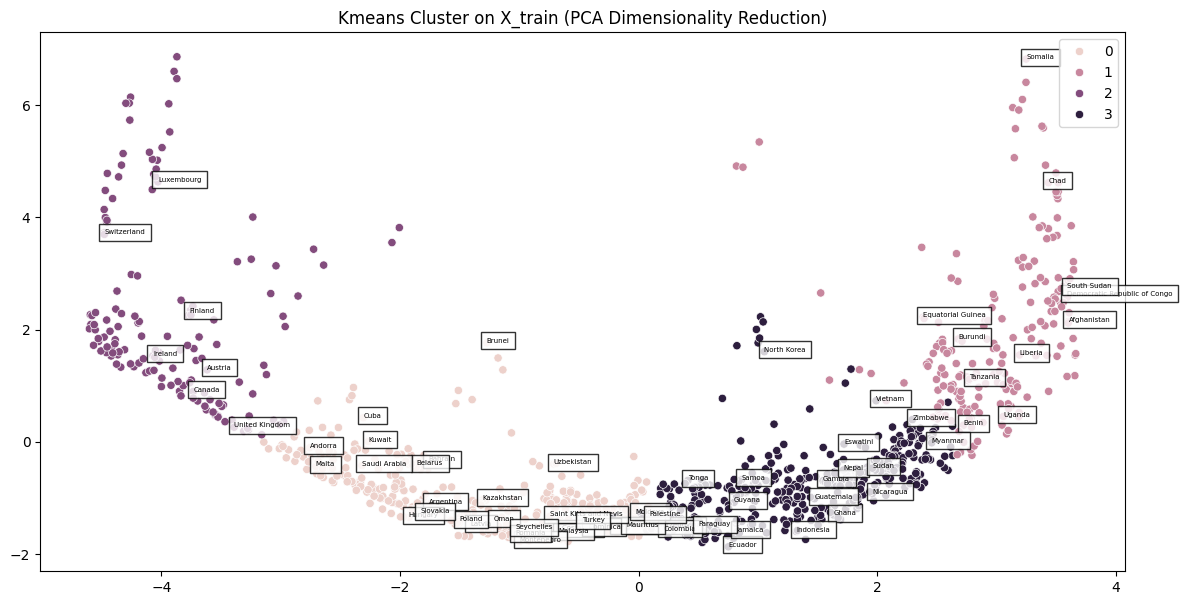

In [24]:
# ----------------------------------
# Visualize Cluster (PCA)
#-----------------------------------
df_imputed = pd.DataFrame(
    X_kmeans_imputed,
    columns=X_cl[num_variables].columns,  
    index=X_cl[num_variables].index      
)

X_cluster_pca = pd.concat([df_imputed, clusters_df], axis=1)
X_cluster_pca["Entity"] = X_cl["Entity"]
X_cluster_dist = X_cluster_pca[["kmeans_dist_0", "kmeans_dist_1", "kmeans_dist_2", "kmeans_dist_3"]]

clusters = X_cluster_dist.values.argmin(axis=1)

X_2d = PCA(n_components=2).fit_transform(X_cluster_dist)
plt.figure(figsize=(14, 7))
sns.scatterplot(x=X_2d[:,0], y=X_2d[:,1], hue=clusters)

n=18
for i, c in enumerate(X_cluster_pca["Entity"]):
    if i % n == 0:
        plt.text(X_2d[i, 0], X_2d[i, 1], c, fontsize=5, bbox=dict(facecolor="white", alpha=0.8))
plt.title("Kmeans Cluster on X_train (PCA Dimensionality Reduction)")
plt.show()

### FunctionTransformer

In [131]:
def ratio_health_gdp(X):
    X = X.copy()
    X["healthspending_gdp_ratio"] = X["annual_healthcare_expenditure_per_capita"] - X["gdp_per_capita_worldbank"]
    return X

ratio_feature = FunctionTransformer(ratio_health_gdp, validate=False, feature_names_out=lambda transformer, input_features: ["gdp_per_capita_worldbank", "annual_healthcare_expenditure_per_capita", "healthspending_gdp_ratio"])

In [132]:
def feature_interactions(X):
    X = X.copy()
    total_medical_staff = X["nurses_and_midwives_per_1000_people"] + X["physicians_per_1000_people"]
    X["urban_x_medical_access"] = total_medical_staff * X["share_of_population_urban"]
    X["urban_x_water_access"] = X["share_of_population_urban"] * X["share_without_improved_water"]
    return X

feature_interactions = FunctionTransformer(feature_interactions, validate=False, feature_names_out=lambda transformer, input_features: ["nurses_and_midwives_per_1000_people", "physicians_per_1000_people", "prevalence_of_undernourishment",
                                                                                                                                     "share_without_improved_water", "vaccination_coverage_who_unicef", "years_of_schooling", "share_of_population_urban",  
                                                                                                                                     "urban_x_medical_access", "urban_x_water_access"])

def create_interaction(df):
    df = df.copy()
    cat_cols = [c for c in df.columns if c.startswith('world_income_group_')]
    for col in cat_cols:
        df[f'schooling_x_{col}'] = df[col] * df['years_of_schooling']
    return df

def get_inter_names(transformer, input_features):
    cat_cols = [c for c in input_features if c.startswith('world_income_group_')]
    new_cols = [f'schooling_x_{c}' for c in cat_cols]
    return list(input_features) + new_cols

### Preprocessing Pipeline

In [135]:
# ----------------------------------
# Preprocessing Pipeline Steps
#-----------------------------------

#impute & transform numeric columns
impute_transform = ColumnTransformer([
    ("log_nums", Pipeline([
        ("knn_impute", KNNImputer(n_neighbors=5, weights="distance")),
        ("log_transform", FunctionTransformer(np.log1p, feature_names_out="one-to-one"))
    ]), skewed_variables),
    
    ("powertransform_nums", Pipeline([
        ("knn_impute2", KNNImputer(n_neighbors=5, weights="distance")),
        ("powertransform", PowerTransformer(method="yeo-johnson"))
    ]), others),
    
    ("normal_dist_nums", Pipeline([
        ("knn_impute3", KNNImputer(n_neighbors=5, weights="distance")),
    ]), normal),

    #("health_gdp_ratio", Pipeline([
    #    ("health_gdp_ratio", ratio_feature),
    #]), [col_gdp, col_healthspending])
        
], verbose_feature_names_out=False, remainder='passthrough').set_output(transform="pandas")

#ratio 
ratio_he_gdp = ColumnTransformer([
    ("health_gdp_ratio", Pipeline([
        ("health_gdp_ratio", ratio_feature),
    ]), [col_gdp, col_healthspending])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#interaction terms
#f_interactions = ColumnTransformer([
#    ("int_terms", Pipeline([
#        ("interactions", feature_interactions),
#    ]), rest_nums)
#], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#cluster
#cluster_ohe = Pipeline(steps=[
#    ("cluster_logic", Cluster(n_clusters=6)), 
#    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
#])

#one hot encode pipeline for categoric cols
categorical_cols = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

#Scale all num cols, ohe & drop country col
scale_ohe_step = ColumnTransformer([
    ("drop_nums", "drop", [col_gdp, col_healthspending]),
    ("scale_nums", RobustScaler(), rest_nums + ["healthspending_gdp_ratio"]), #, "urban_x_medical_access", "urban_x_water_access"]),
    ("ohe_cat", categorical_cols, [col_regions, col_incomegroup]),
    #("ohe_cluster", cluster_ohe, rest_nums),
    ("drop_country", "drop", [col_country])
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

#combine steps for model pipeline
end_pipe = Pipeline([
    ("prep_nums", impute_transform),
    ("ratio_feature", ratio_he_gdp),
    #("interactionterms", f_interactions),
    #("ratio_feature", ratio),
    #("relative_to_mean", RelativeToCountryMean(
    #    country_col=col_country, 
    #    num_cols=all_numeric_cols
    #)),
    #("transf_nums", nums_transf),
    ("scale_ohe", scale_ohe_step),
    #('interaction', FunctionTransformer(create_interaction, feature_names_out=get_inter_names)),
    #("cluster", cluster_ohe),
    #("final_impute", KNNImputer(n_neighbors=5, weights="distance")),
]).set_output(transform="pandas")

gk = GroupKFold(n_splits=7)

### Linear Regression (Baseline)

In [136]:
from sklearn.model_selection import cross_validate
# -------------------------------------------------
# BASELINE MODEL: LINEAR REGRESSION  NON-REGULARIZED
#--------------------------------------------------
lr_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", LinearRegression())
])

#Target is rightskewed, logtransform y before training
#lr_pipeline_y_log = TransformedTargetRegressor(
#    regressor=lr_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

lr_r2_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="r2")
lr_mae_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="neg_mean_absolute_error")
lr_rmse_cv = cross_val_score(lr_pipeline, X_train, y_train, groups=group_train, cv=gk, scoring="neg_root_mean_squared_error")
lr_r2_score = lr_r2_cv
lr_mae_score = -lr_mae_cv
lr_rmse_score = -lr_rmse_cv
# print crossvalidations scores (splitted into gk-folds (5), fit on gk - 1 & evaluate on last fold > iterate 5times)
print("\n------LINEAR REGRESSION CV SCORES--------")
print("\nR2:")
print(f"\nFolds R2 scores: {lr_r2_score}\nMean R2 Score: {round(lr_r2_score.mean(), 2)}\nStd R2: {round(lr_r2_score.std(), 2)}")
print("\nMAE:")
#print(f"MAE error in relation to mean target: {round( (lr_mae_score.mean() / target_mean()) * 100, 2 )} %")
print(f"\nFolds MAE scores: {lr_mae_score}\nMean MAE Score: {round(lr_mae_score.mean(), 2)}\nStd MAE: {round(lr_mae_score.std(), 2)}")
print("\nRMSE:")
print(f"\nFolds RMSE scores: {lr_rmse_score}\nMean RMSE Score: {round(lr_rmse_score.mean(), 2)}\nStd RMSE: {round(lr_rmse_score.std(), 2)}\n")
print("-----------------------------------------\n")


lr_cv_results = cross_validate(
    estimator=lr_pipeline,
    X=X_train,
    y=y_train,
    groups=group_train,          
    cv=gk,
    scoring=metrics,
    return_train_score=True,
    return_estimator=True
)
print(f'Train r2 mean: {lr_cv_results["train_r2"].mean()}, Train mae mean: {-lr_cv_results["train_mae"].mean()}, Train rmse mean: {-lr_cv_results["train_rmse"].mean()}')


------LINEAR REGRESSION CV SCORES--------

R2:

Folds R2 scores: [0.63277252 0.82550658 0.56313496 0.56333714 0.67729193 0.80694754
 0.79445652]
Mean R2 Score: 0.69
Std R2: 0.11

MAE:

Folds MAE scores: [11.52340054  9.46174421 12.95561035 15.23812534 11.88380383 12.25358621
 14.23827096]
Mean MAE Score: 12.51
Std MAE: 1.75

RMSE:

Folds RMSE scores: [14.82358894 11.45615333 17.12616757 30.65088535 17.54100447 17.14694254
 20.15006971]
Mean RMSE Score: 18.41
Std RMSE: 5.58

-----------------------------------------

Train r2 mean: 0.7616867510500706, Train mae mean: 11.016495005729505, Train rmse mean: 17.381096359124605


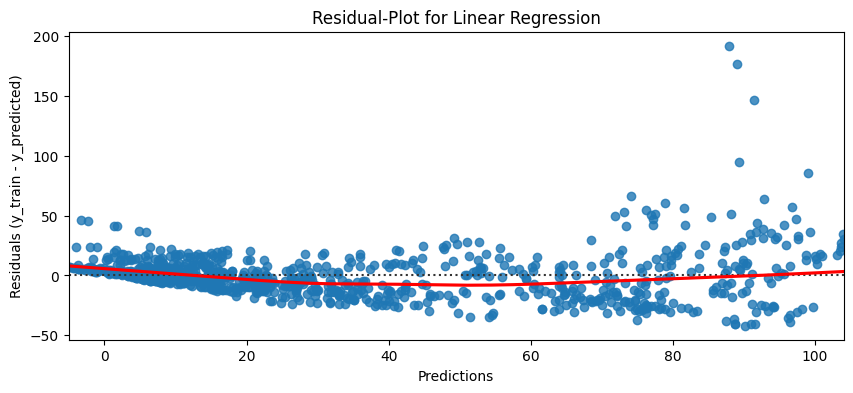

In [137]:
# -------------------------------------------------
# RESIDUAL PLOT FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
lr_y_predicts = cross_val_predict(lr_pipeline, X_train, y_train, groups=group_train, cv=gk)
lr_residuals = y_train - lr_y_predicts

#lr_y_predicts = cross_val_predict(lr_pipeline_y_log, X_train_norm, y_train_norm, groups=groups_train_norm, cv=gk)
#lr_residuals = y_train_norm - lr_y_predicts

residual_plot(lr_y_predicts, lr_residuals, "Linear Regression")

In [138]:
# Metrics Comparison by Region / Income Group
metrics_per_group(X_train, y_train, lr_y_predicts, "world_regions_wb")
metrics_per_group(X_train, y_train, lr_y_predicts, "world_income_group")


Metrics comparison between world_regions_wb:

Middle East, North Africa, Afghanistan and Pakistan (WB) RMSE: 11.1251
Middle East, North Africa, Afghanistan and Pakistan (WB) MAE: 7.5978
Europe and Central Asia (WB) RMSE: 11.0734
Europe and Central Asia (WB) MAE: 7.5094
Sub-Saharan Africa (WB) RMSE: 31.4011
Sub-Saharan Africa (WB) MAE: 22.8627
Latin America and Caribbean (WB) RMSE: 9.6726
Latin America and Caribbean (WB) MAE: 7.5184
East Asia and Pacific (WB) RMSE: 12.1262
East Asia and Pacific (WB) MAE: 10.0466
South Asia (WB) RMSE: 19.0994
South Asia (WB) MAE: 17.2204
North America (WB) RMSE: 5.5476
North America (WB) MAE: 5.5425

Metrics comparison between world_income_group:

Low-income countries RMSE: 34.6986
Low-income countries MAE: 24.5562
Upper-middle-income countries RMSE: 12.0739
Upper-middle-income countries MAE: 8.9969
High-income countries RMSE: 8.0455
High-income countries MAE: 5.7626
Lower-middle-income countries RMSE: 17.1688
Lower-middle-income countries MAE: 13.9718


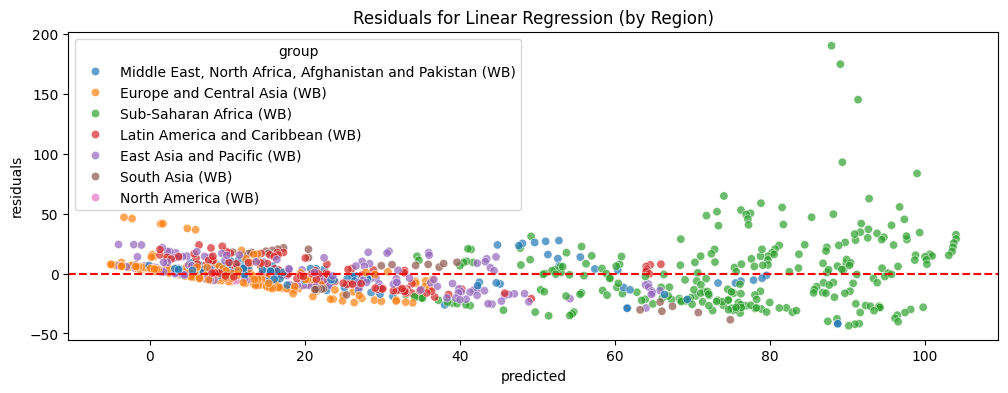

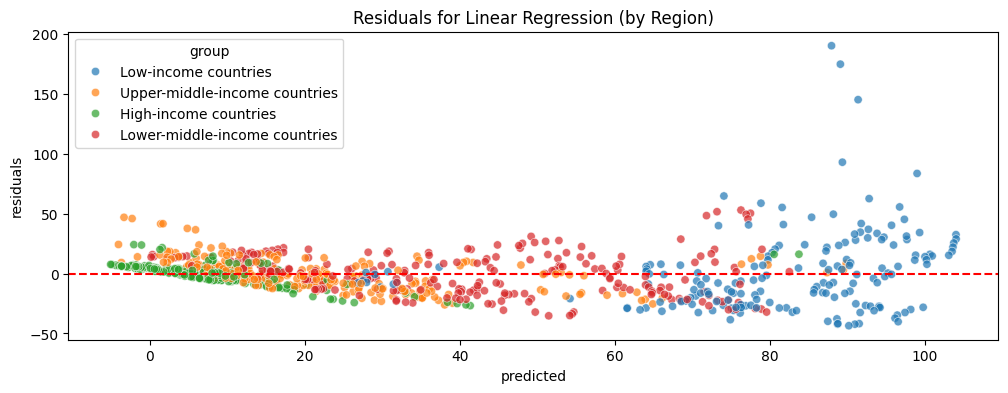

In [196]:
#Resiudal Plots per Region/Income Group
residual_plot_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_regions_wb", "Linear Regression (by Region)")
residual_plot_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_income_group", "Linear Regression (by Region)")
res_by_region = residuals_sorted(X_train, y_train, lr_y_predicts, lr_residuals, "world_regions_wb")
res_by_income = residuals_sorted(X_train, y_train, lr_y_predicts, lr_residuals, "world_income_group")

In [211]:
#Variances by Region / Income Group to see Heteroscedasticity
variances_ig = res_by_income.groupby("group")["residuals"].agg(["var", "std", "count"])
print(variances_ig)
variances_reg = res_by_region.groupby("group")["residuals"].agg(["var", "std", "count"])
print(variances_reg)

                                       var        std  count
group                                                       
High-income countries            64.851604   8.053049    229
Low-income countries           1210.440316  34.791383    180
Lower-middle-income countries   295.927381  17.202540    238
Upper-middle-income countries   145.946731  12.080842    277
                                                           var        std  \
group                                                                       
East Asia and Pacific (WB)                          147.577810  12.148161   
Europe and Central Asia (WB)                        122.896688  11.085878   
Latin America and Caribbean (WB)                     94.146610   9.702918   
Middle East, North Africa, Afghanistan and Paki...  124.359329  11.151651   
North America (WB)                                    0.068104   0.260968   
South Asia (WB)                                     377.037222  19.417446   
Sub-Saharan Africa

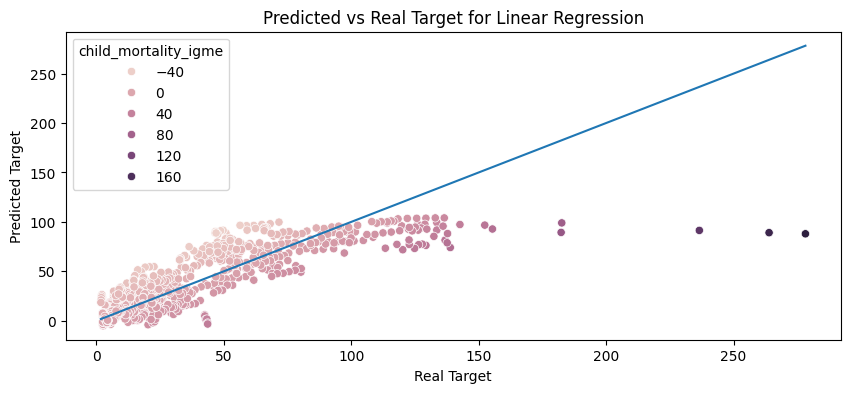

In [140]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR BASE MODEL: LINEAR REGRESSION NON-REGULARIZED
#--------------------------------------------------
actual_vs_predicted(y_train, lr_y_predicts, lr_residuals, "Linear Regression")

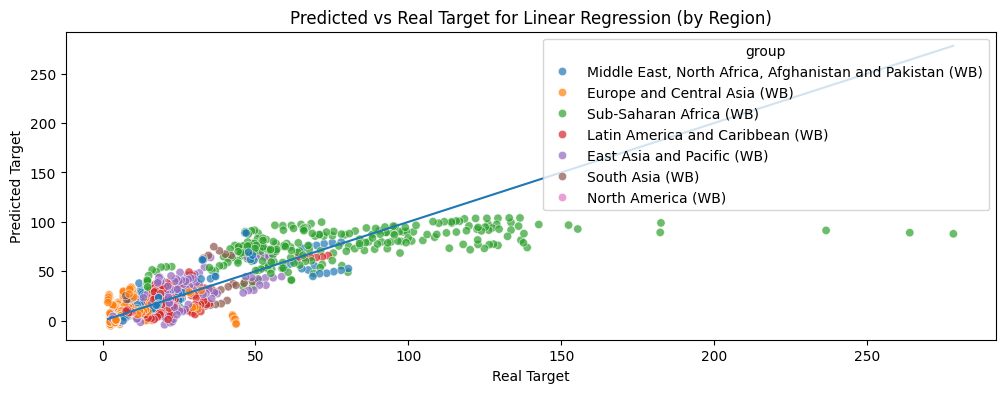

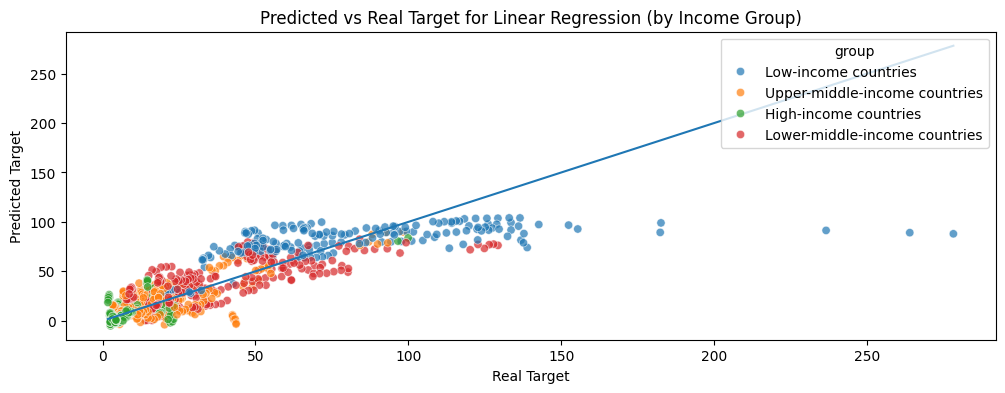

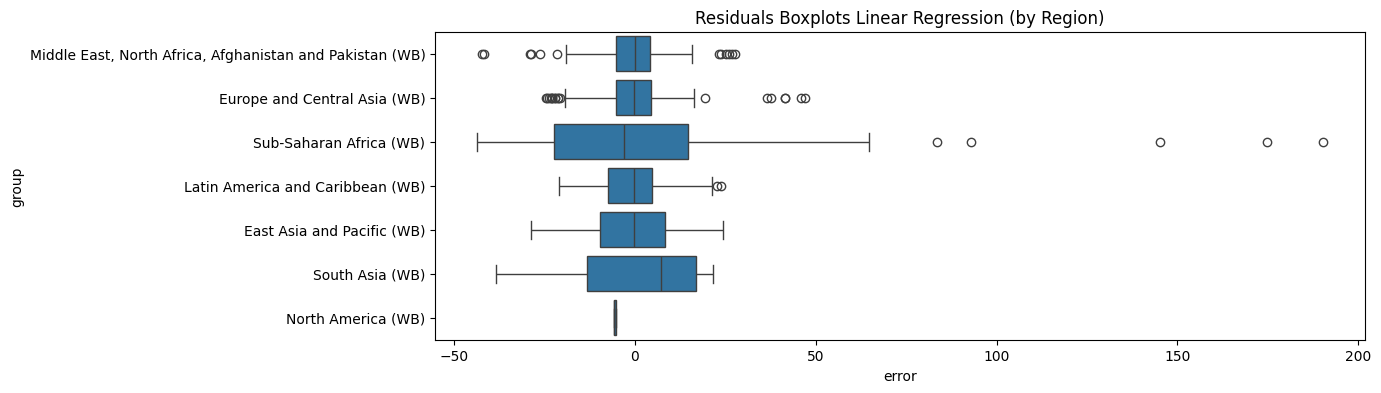

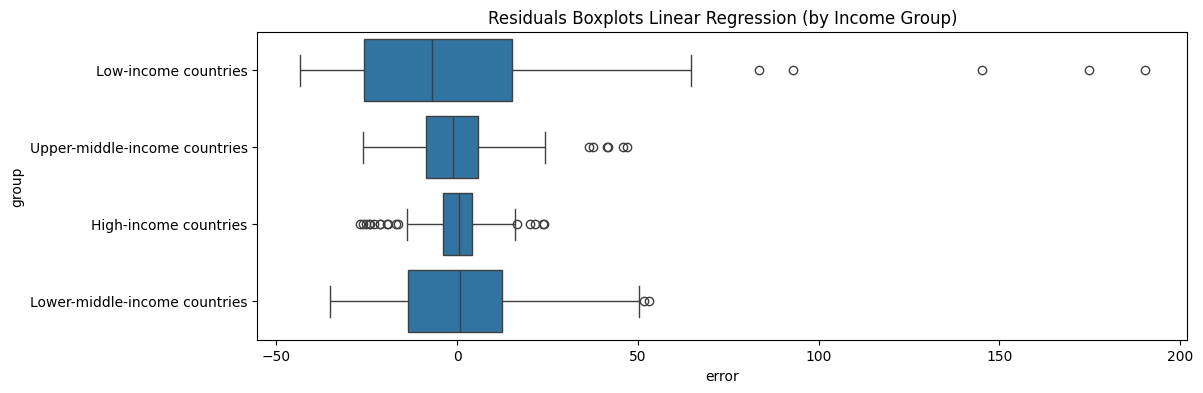

In [141]:
# -------------------------------------------------
# PREDICED VS REAL + BOXPLOTS FOR BASE MODEL: LINEAR REGRESSION BY GROUP
#--------------------------------------------------
actual_vs_predicted_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_regions_wb", "Linear Regression (by Region)")
actual_vs_predicted_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_income_group", "Linear Regression (by Income Group)")
boxplots_residuals(X_train, y_train, lr_y_predicts, lr_residuals, "world_regions_wb", "Linear Regression (by Region)")
boxplots_residuals(X_train, y_train, lr_y_predicts, lr_residuals, "world_income_group", "Linear Regression (by Income Group)")

In [142]:
#print all feature columns
first_fitted_estimatorlr = lr_cv_results['estimator'][0]
#feature_pipelinelr = first_fitted_estimatorlr.regressor_
pre_pipelinelr = first_fitted_estimatorlr.named_steps['preprocess']
#last_transformerlr = pre_pipelinelr.steps[-1][1]
feature_names_finallr = pre_pipelinelr.get_feature_names_out()

lr_coefs = first_fitted_estimatorlr.named_steps["model"].coef_

np.set_printoptions(threshold=np.inf)
print(f"Feature-Namen:")
print(feature_names_finallr)
print(f"Feature-Coeff:")
print(lr_coefs)

Feature-Namen:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthspending_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries']
Feature-Coeff:
[ -1.99161847   2.48108489   2.92686104  12.58448404 -14.47335771
 -11.67428316   0.68079961  -0.44254258  -5.62222826  -4.0812986
  -4.86804104  -2.5674954   -4.89132478  -0.55662479  22.5

#### Holdout Testset

In [143]:
lr_pipeline.fit(X_train, y_train)

holdout_test(lr_pipeline, X_test)  

----Holdout Testset: Final Metric Scores----
 MAE: 7.41855882297549, R2: 0.793923206607996, RMSE: 10.267247927369128
[ 5.28377896  9.70924334 16.67321037 20.83437953]


### Ridge

In [145]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL (RIDGE)
#--------------------------------------------------
ridge_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", Ridge())
])

#Target is rightskewed, logtransform y before training
#ridge_pipeline_y_log  = TransformedTargetRegressor(
#    regressor=ridge_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

ridge_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 30, 40]
}
# fit trainset via GridSearchCV
ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
ridge_grid.fit(X_train, y_train, groups=group_train)
best_ridge_model = ridge_grid.best_estimator_
# print metrics scores
show_scores(ridge_grid, "Ridge")
ridge_grid.best_estimator_


------Ridge CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.76), np.float64(0.74), np.float64(0.76), np.float64(0.8)]
            
Mean Train R2 Score: 0.76
            
Test Folds R2 Scores: [np.float64(0.65), np.float64(0.85), np.float64(0.66), np.float64(0.56)]
            
Mean Test R2 Score (best_score_): 0.72)   
            
Std Test R2 Score: 0.1

MAE:

Train Folds MAE Scores: [np.float64(11.03), np.float64(11.62), np.float64(11.26), np.float64(10.16)]
            
Mean Train MAE Score: 10.94
            
Test Folds MAE Scores: [np.float64(11.29), np.float64(8.59), np.float64(12.05), np.float64(15.57)]
            
Mean Test MAE Score: 12.0
            
Std Test MAE Score: 2.04

RMSE:

Train Folds RMSE Scores: [np.float64(18.26), np.float64(18.64), np.float64(18.15), np.float64(14.76)]
            
Mean Train RMSE Score: 17.59
            
Test Folds RMSE Scores: [np.float64(14.45), np.float64(10.66), np.float64(15.14), np.float64(30.81)]
            
Mean Test RM

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                    'share_of_population_urban',
                                                                    'healthspending_gdp_ratio']),
                                                                  ('ohe_cat',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False))])),
                ('model', Ridge(alpha=40))])

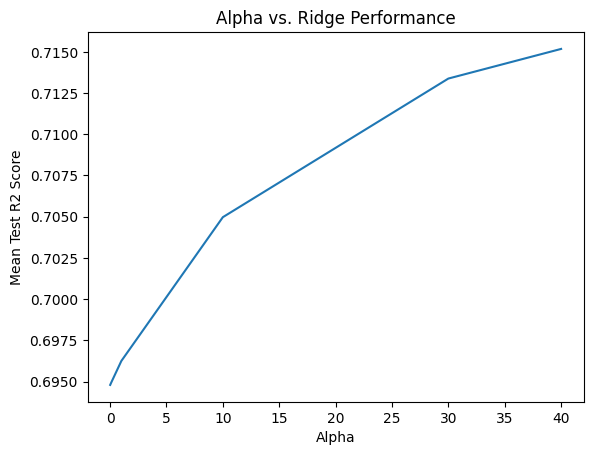

In [147]:
#show lineplot - best alpha - r2 score
ridge_results = pd.DataFrame(ridge_grid.cv_results_)
sns.lineplot(x=ridge_results['param_model__alpha'], y=ridge_results['mean_test_r2'])
plt.title("Alpha vs. Ridge Performance")
plt.xlabel("Alpha")
plt.ylabel("Mean Test R2 Score")
plt.show()

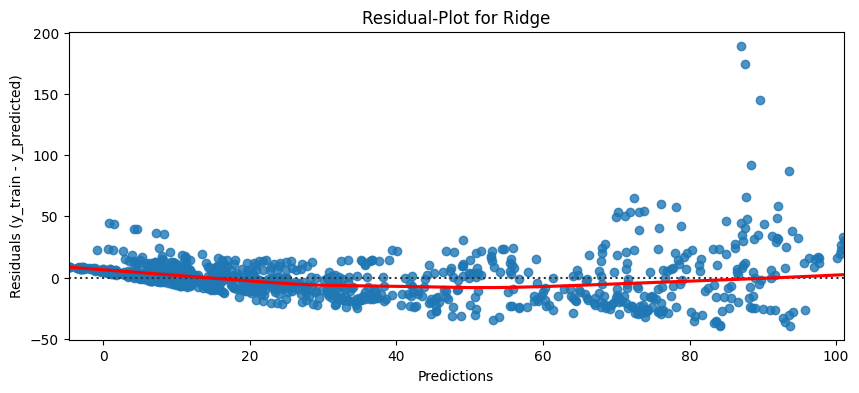

In [149]:
ridge_y_predicts = cross_val_predict(best_ridge_model, X_train, y_train, groups=group_train, cv=gk)
ridge_residuals = y_train - ridge_y_predicts

residual_plot(ridge_y_predicts, ridge_residuals, "Ridge")

In [150]:
# Metrics Comparison by Region / Income Group
metrics_per_group(X_train, y_train, ridge_y_predicts, "world_regions_wb")
metrics_per_group(X_train, y_train, ridge_y_predicts, "world_income_group")


Metrics comparison between world_regions_wb:

Middle East, North Africa, Afghanistan and Pakistan (WB) RMSE: 10.0058
Middle East, North Africa, Afghanistan and Pakistan (WB) MAE: 6.9311
Europe and Central Asia (WB) RMSE: 10.3397
Europe and Central Asia (WB) MAE: 6.9808
Sub-Saharan Africa (WB) RMSE: 31.4810
Sub-Saharan Africa (WB) MAE: 22.7481
Latin America and Caribbean (WB) RMSE: 9.5684
Latin America and Caribbean (WB) MAE: 7.4788
East Asia and Pacific (WB) RMSE: 11.9804
East Asia and Pacific (WB) MAE: 9.8874
South Asia (WB) RMSE: 12.5321
South Asia (WB) MAE: 10.1356
North America (WB) RMSE: 4.5635
North America (WB) MAE: 4.5590

Metrics comparison between world_income_group:

Low-income countries RMSE: 34.6184
Low-income countries MAE: 24.2114
Upper-middle-income countries RMSE: 11.1634
Upper-middle-income countries MAE: 8.4469
High-income countries RMSE: 7.5214
High-income countries MAE: 5.5578
Lower-middle-income countries RMSE: 16.7536
Lower-middle-income countries MAE: 13.0872


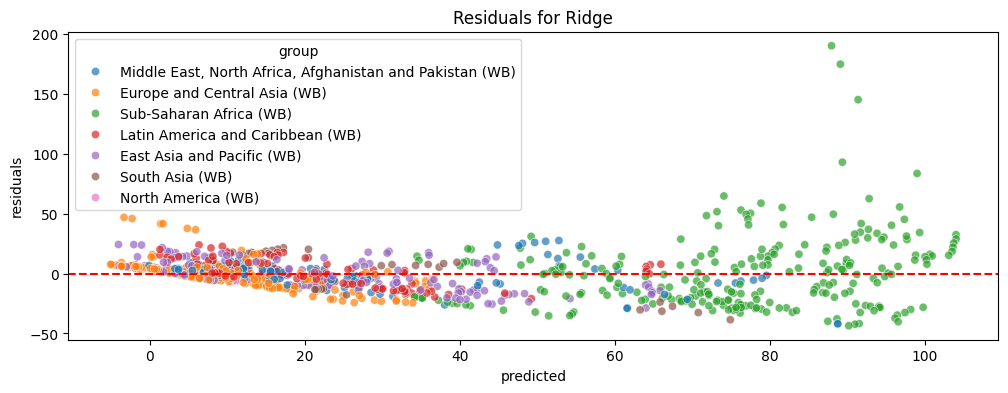

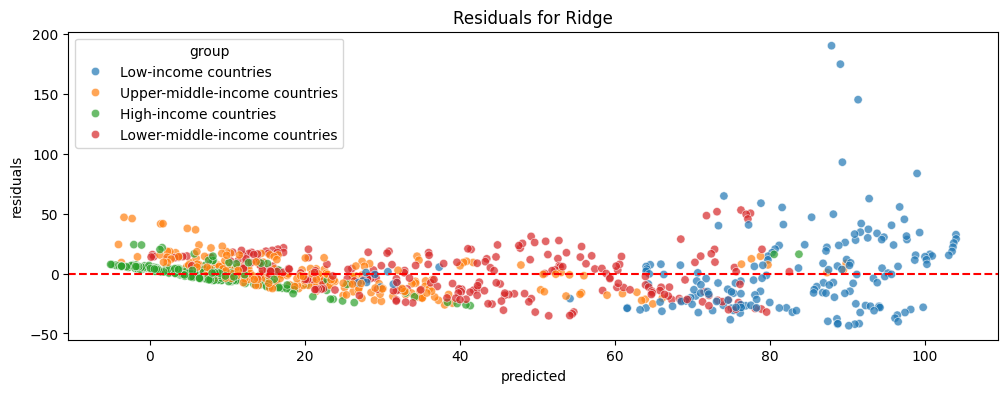

In [151]:
residual_plot_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_regions_wb", "Ridge")
residual_plot_regions(X_train, y_train, lr_y_predicts, lr_residuals, "world_income_group", "Ridge")

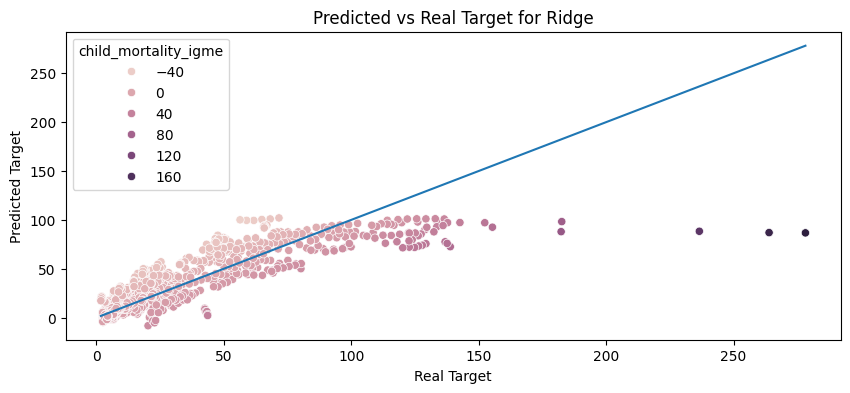

In [475]:
actual_vs_predicted(y_train, ridge_y_predicts, ridge_residuals, "Ridge")

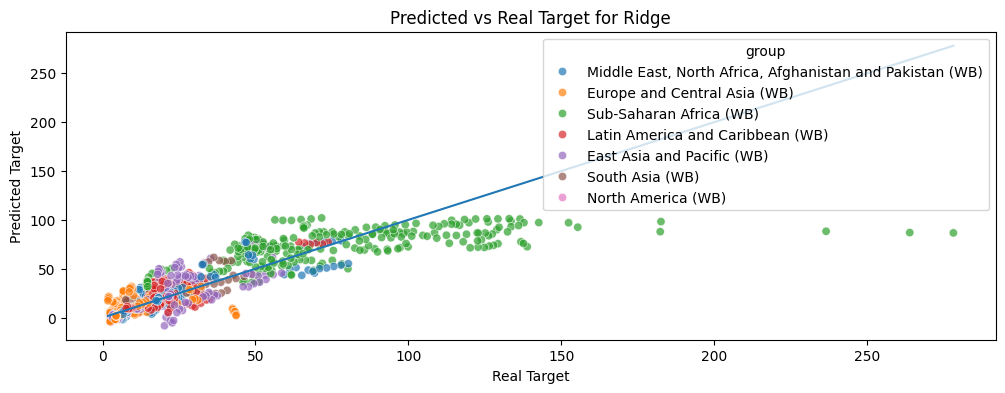

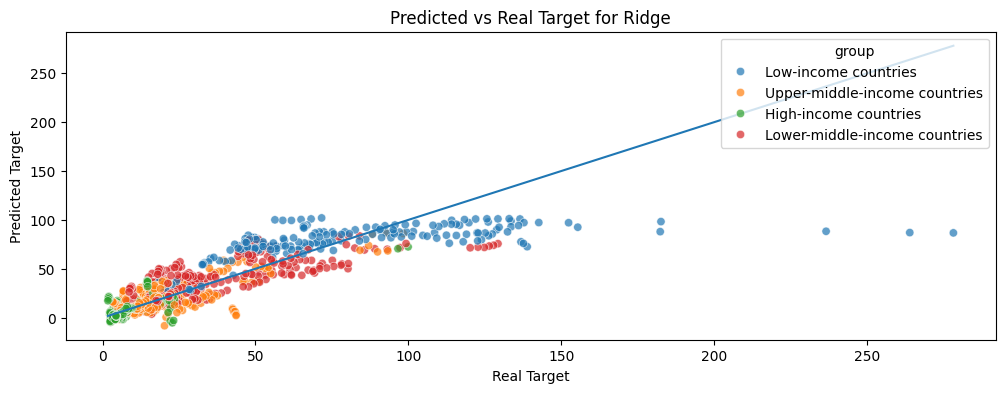

In [476]:
actual_vs_predicted_regions(X_train, y_train, ridge_y_predicts, ridge_residuals, "world_regions_wb", "Ridge")
actual_vs_predicted_regions(X_train, y_train, ridge_y_predicts, ridge_residuals, "world_income_group", "Ridge")

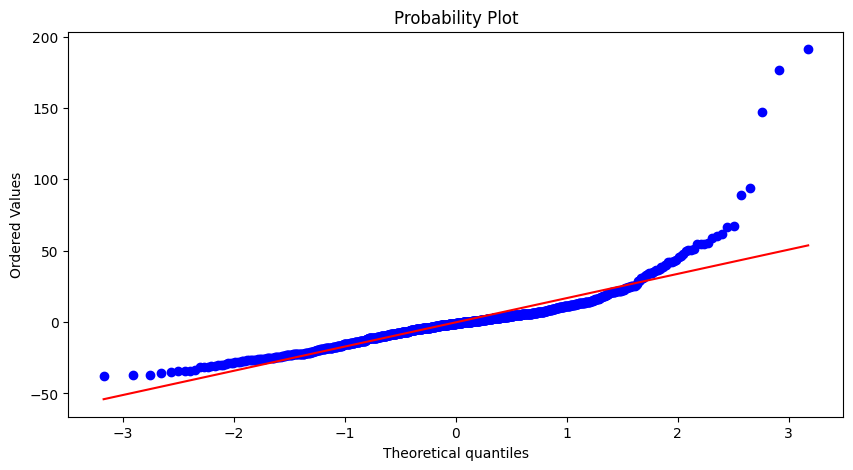

In [89]:
#prob. plot: shows heavy tails
prob_plot(ridge_residuals)

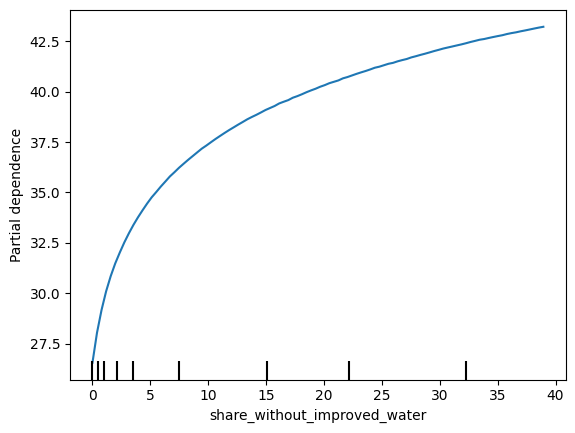

In [39]:
from sklearn.inspection import PartialDependenceDisplay
#prediction decreases when gdp_per_capita increases
#prediction decreases when vaccination_coverage increases
PartialDependenceDisplay.from_estimator(best_ridge_model, X_train, ["share_without_improved_water"])

#### Holdout Testset

In [157]:
#best_ridge_model.fit(X_train, y_train)

holdout_test(best_ridge_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.086366503227923, R2: 0.8077972423033468, RMSE: 9.9156071625723
[ 4.94022115  9.61343701 17.28049633 20.2515383 ]


In [44]:
ridge_feature_pipeline = best_ridge_model
pre_pipeline_ridge = ridge_feature_pipeline.named_steps['preprocess']
#last_transformer_ridge = pre_pipeline_ridge.steps[-1][1]
feature_names_final_ridge = pre_pipeline_ridge.get_feature_names_out()

In [45]:
pi_result_ridge = permutation_importance(best_ridge_model, X_test, y_test, n_repeats=10, random_state=42)
importance_df_ridge = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_ridge.importances_mean, 4),
    'importance_std': np.round(pi_result_ridge.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_ridge

feature  importance_mean  importance_std
8            vaccination_coverage_who_unicef           0.1704          0.0133
10                          world_regions_wb           0.1626          0.0319
7               share_without_improved_water           0.1115          0.0158
9                         years_of_schooling           0.0693          0.0165
1   annual_healthcare_expenditure_per_capita           0.0601          0.0109
11                        world_income_group           0.0205          0.0063
2                   gdp_per_capita_worldbank           0.0196          0.0058
3        nurses_and_midwives_per_1000_people           0.0139          0.0066
6                  share_of_population_urban           0.0093          0.0025
4                 physicians_per_1000_people           0.0008          0.0013
0                                     Entity           0.0000          0.0000
5             prevalence_of_undernourishment          -0.0050          0.0047

### ElasticNet

In [152]:
# -------------------------------------------------
# REGULARIZED LINEAR MODEL ELASTICNET
#--------------------------------------------------
elasticnet_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", ElasticNet(max_iter=5000, random_state=99))
])
#Target is rightskewed, logtransform y before training
#elasticnet_pipeline_y_log = TransformedTargetRegressor(
#    regressor=elasticnet_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

elasticnet_param_grid = {
    "model__alpha": [0.01, 0.1, 1, 10, 30, 60, 90],
    "model__l1_ratio": [0.1, 0.2, 0.5, 0.8]
}

elasticnet_grid = GridSearchCV(elasticnet_pipeline, elasticnet_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
elasticnet_grid.fit(X_train, y_train, groups=group_train)
best_elasticnet_model = elasticnet_grid.best_estimator_

show_scores(elasticnet_grid, "ElasticNet")

elasticnet_grid.best_estimator_
#pd.DataFrame(elasticnet_grid.cv_results_)


------ElasticNet CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.75), np.float64(0.73), np.float64(0.75), np.float64(0.8)]
            
Mean Train R2 Score: 0.75
            
Test Folds R2 Scores: [np.float64(0.65), np.float64(0.85), np.float64(0.69), np.float64(0.55)]
            
Mean Test R2 Score (best_score_): 0.72)   
            
Std Test R2 Score: 0.1

MAE:

Train Folds MAE Scores: [np.float64(11.11), np.float64(11.65), np.float64(11.3), np.float64(10.22)]
            
Mean Train MAE Score: 10.98
            
Test Folds MAE Scores: [np.float64(11.17), np.float64(8.31), np.float64(11.73), np.float64(15.99)]
            
Mean Test MAE Score: 11.94
            
Std Test MAE Score: 2.2

RMSE:

Train Folds RMSE Scores: [np.float64(18.51), np.float64(18.9), np.float64(18.41), np.float64(15.07)]
            
Mean Train RMSE Score: 17.85
            
Test Folds RMSE Scores: [np.float64(14.42), np.float64(10.5), np.float64(14.53), np.float64(31.11)]
            
Mean Test 

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                  ('ohe_cat',
                                                                   Pipeline(steps=[('imp',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=5000,
                            random_state=99))])

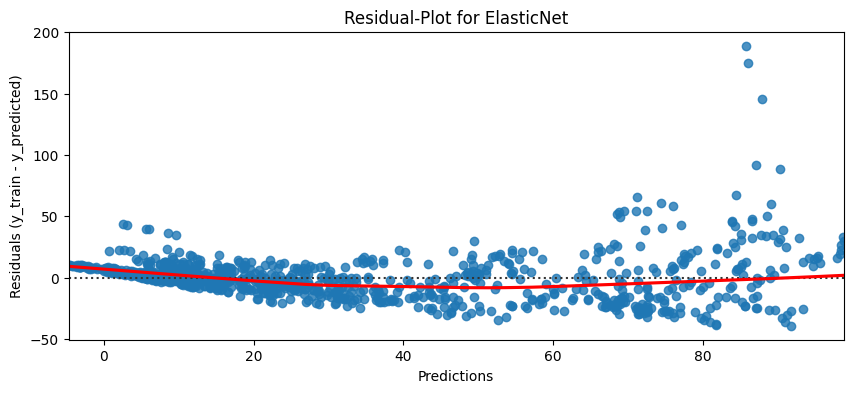

In [153]:
# -------------------------------------------------
# RESIDUAL PLOT FOR ELASTICNET
#--------------------------------------------------
elasticnet_y_predicts = cross_val_predict(best_elasticnet_model, X_train, y_train, groups=group_train, cv=gk)
elasticnet_residuals = y_train - elasticnet_y_predicts

residual_plot(elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

In [154]:
# Metrics Comparison by Region / Income Group
metrics_per_group(X_train, y_train, elasticnet_y_predicts, "world_regions_wb")
metrics_per_group(X_train, y_train, elasticnet_y_predicts, "world_income_group")


Metrics comparison between world_regions_wb:

Middle East, North Africa, Afghanistan and Pakistan (WB) RMSE: 9.6060
Middle East, North Africa, Afghanistan and Pakistan (WB) MAE: 6.6318
Europe and Central Asia (WB) RMSE: 10.0089
Europe and Central Asia (WB) MAE: 6.8617
Sub-Saharan Africa (WB) RMSE: 31.8138
Sub-Saharan Africa (WB) MAE: 22.8001
Latin America and Caribbean (WB) RMSE: 9.6271
Latin America and Caribbean (WB) MAE: 7.6418
East Asia and Pacific (WB) RMSE: 12.1246
East Asia and Pacific (WB) MAE: 9.9339
South Asia (WB) RMSE: 11.5378
South Asia (WB) MAE: 8.9664
North America (WB) RMSE: 4.1625
North America (WB) MAE: 4.1576

Metrics comparison between world_income_group:

Low-income countries RMSE: 34.9386
Low-income countries MAE: 24.2625
Upper-middle-income countries RMSE: 10.9802
Upper-middle-income countries MAE: 8.4162
High-income countries RMSE: 7.3936
High-income countries MAE: 5.4582
Lower-middle-income countries RMSE: 16.8180
Lower-middle-income countries MAE: 12.9463


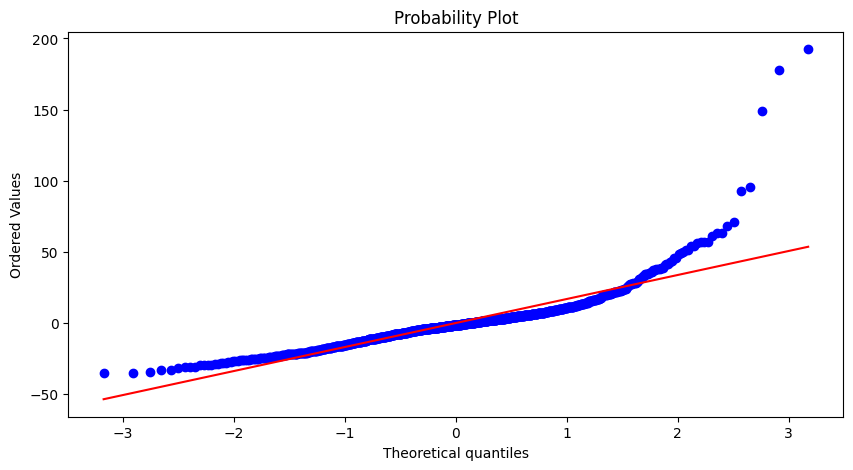

In [48]:
# -------------------------------------------------
# Quantile-Quantile-Plot OF RESIDUALS FOR ELASTICNET 
#--------------------------------------------------
prob_plot(elasticnet_residuals)

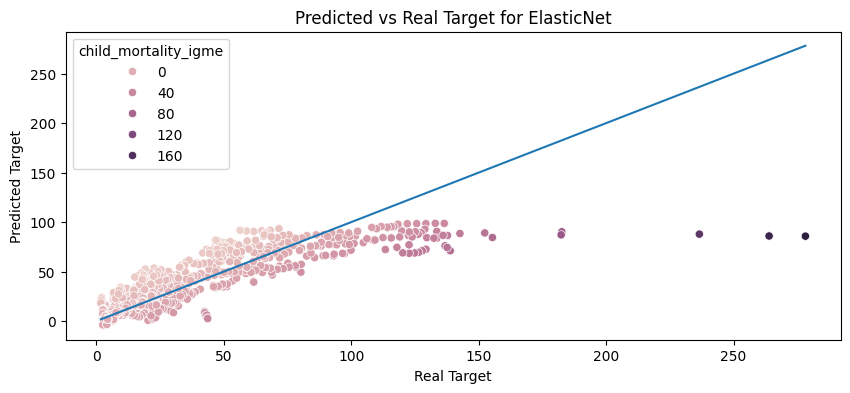

In [49]:
# -------------------------------------------------
# SCATTER PREDICED VS REAL FOR ELASTUCNET
#--------------------------------------------------
#actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")
actual_vs_predicted(y_train, elasticnet_y_predicts, elasticnet_residuals, "ElasticNet")

In [50]:
pi_result_el = permutation_importance(best_elasticnet_model, X_test, y_test, n_repeats=40, random_state=42)
importance_df_el = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_el.importances_mean, 4),
    'importance_std': np.round(pi_result_el.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_el

feature  importance_mean  importance_std
8            vaccination_coverage_who_unicef           0.1431          0.0209
10                          world_regions_wb           0.1368          0.0178
7               share_without_improved_water           0.0922          0.0135
1   annual_healthcare_expenditure_per_capita           0.0644          0.0120
9                         years_of_schooling           0.0623          0.0123
11                        world_income_group           0.0243          0.0062
2                   gdp_per_capita_worldbank           0.0234          0.0070
3        nurses_and_midwives_per_1000_people           0.0193          0.0077
6                  share_of_population_urban           0.0079          0.0035
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0003          0.0014
5             prevalence_of_undernourishment          -0.0055          0.0036

#### Holdout Test

In [156]:
#best_elasticnet_model.fit(X_train, y_train)

holdout_test(best_elasticnet_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.295058233260784, R2: 0.807223072792007, RMSE: 9.930406621894583
[ 4.81511266 10.08441017 16.93758179 20.10172885]


### Random Forest

In [155]:
# -------------------------------------------------
# RF
#--------------------------------------------------
rf_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", RandomForestRegressor(random_state=99))
])
#Target is rightskewed, logtransform y before training
#rf_pipeline_y_log = TransformedTargetRegressor(
#    regressor=rf_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

rf_param_grid = {
    "model__n_estimators": [300, 500],
    "model__max_depth": [1, 3],
    "model__min_samples_split": [5, 15],
    "model__min_samples_leaf": [20, 30],
    "model__max_features": [0.2],
    "model__max_samples": [0.7, 0.8]
}

rf_grid = GridSearchCV(rf_pipeline, rf_param_grid, cv=gk, scoring=metrics, refit="mae", return_train_score=True, n_jobs=-1)
rf_grid.fit(X_train, y_train, groups=group_train)
best_rf_model = rf_grid.best_estimator_

show_scores(rf_grid, "RF")
rf_grid.best_estimator_


------RF CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.78), np.float64(0.75), np.float64(0.76), np.float64(0.82)]
            
Mean Train R2 Score: 0.77
            
Test Folds R2 Scores: [np.float64(0.56), np.float64(0.87), np.float64(0.78), np.float64(0.51)]
            
Mean Test R2 Score (best_score_): 0.71)   
            
Std Test R2 Score: 0.12

MAE:

Train Folds MAE Scores: [np.float64(10.43), np.float64(10.97), np.float64(10.88), np.float64(9.49)]
            
Mean Train MAE Score: 10.28
            
Test Folds MAE Scores: [np.float64(12.26), np.float64(8.13), np.float64(9.33), np.float64(16.95)]
            
Mean Test MAE Score: 11.99
            
Std Test MAE Score: 2.66

RMSE:

Train Folds RMSE Scores: [np.float64(17.51), np.float64(18.32), np.float64(17.99), np.float64(14.24)]
            
Mean Train RMSE Score: 17.12
            
Test Folds RMSE Scores: [np.float64(16.27), np.float64(9.97), np.float64(12.04), np.float64(32.37)]
            
Mean Test RMSE 

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['world_regions_wb',
                                                                    'world_income_group']),
                                                                  ('drop_country',
                                                                   'drop',
                                                                   ['Entity'])],
                                                    verbose_feature_names_out=False))])),
                ('model',
                 RandomForestRegressor(max_depth=3, max_features=0.2,
                                       max_samples=0.8, min_samples_leaf=20,
                                       min_samples_split=5, n_estimators=500,
                                       random_state=99))])

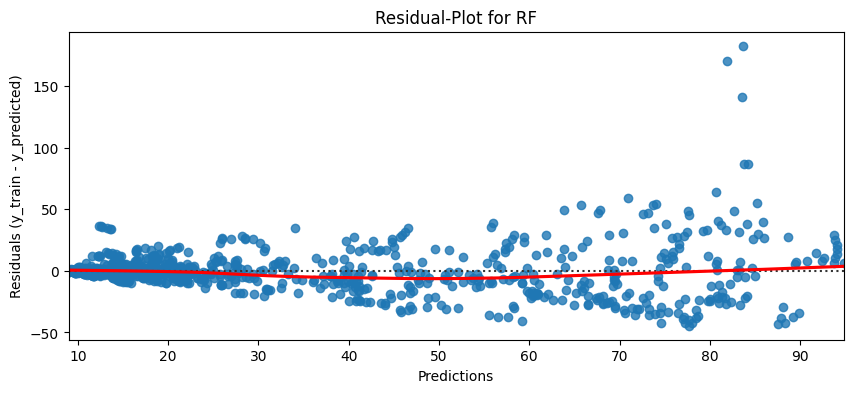

In [158]:
rf_y_predicts = cross_val_predict(best_rf_model, X_train, y_train, groups=group_train, cv=gk)
rf_residuals = y_train - rf_y_predicts

residual_plot(rf_y_predicts, rf_residuals, "RF")

In [159]:
# Metrics Comparison by Region / Income Group
metrics_per_group(X_train, y_train, rf_y_predicts, "world_regions_wb")
metrics_per_group(X_train, y_train, rf_y_predicts, "world_income_group")


Metrics comparison between world_regions_wb:

Middle East, North Africa, Afghanistan and Pakistan (WB) RMSE: 10.5498
Middle East, North Africa, Afghanistan and Pakistan (WB) MAE: 7.5323
Europe and Central Asia (WB) RMSE: 8.6295
Europe and Central Asia (WB) MAE: 7.1169
Sub-Saharan Africa (WB) RMSE: 33.2869
Sub-Saharan Africa (WB) MAE: 23.6432
Latin America and Caribbean (WB) RMSE: 7.6101
Latin America and Caribbean (WB) MAE: 5.7795
East Asia and Pacific (WB) RMSE: 11.8191
East Asia and Pacific (WB) MAE: 9.4467
South Asia (WB) RMSE: 11.0940
South Asia (WB) MAE: 9.0327
North America (WB) RMSE: 5.7029
North America (WB) MAE: 5.7020

Metrics comparison between world_income_group:

Low-income countries RMSE: 35.8127
Low-income countries MAE: 24.0087
Upper-middle-income countries RMSE: 10.6815
Upper-middle-income countries MAE: 8.0246
High-income countries RMSE: 7.8546
High-income countries MAE: 6.6332
Lower-middle-income countries RMSE: 17.3482
Lower-middle-income countries MAE: 12.6581


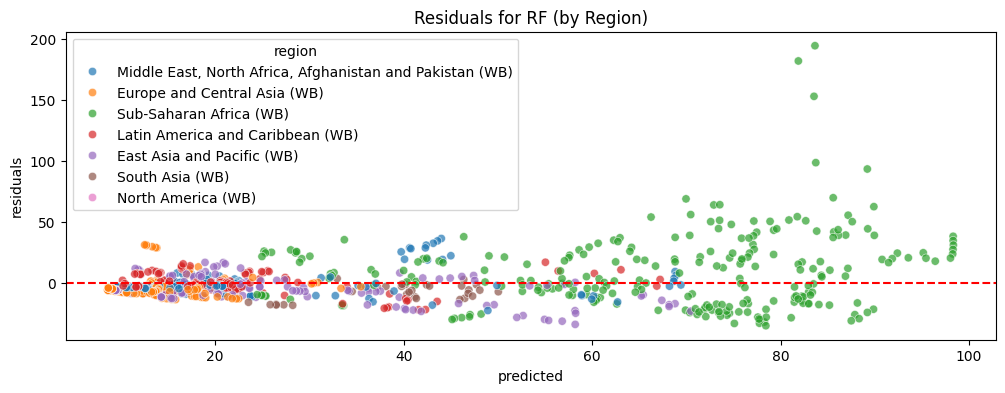

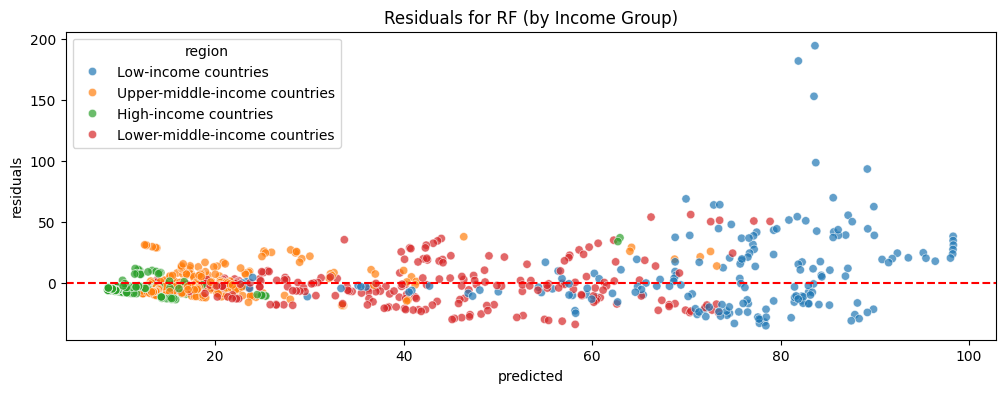

In [102]:
residual_plot_regions(y_train, rf_y_predicts, rf_residuals, "world_regions_wb", "RF (by Region)")
residual_plot_regions(y_train, rf_y_predicts, rf_residuals, "world_income_group", "RF (by Income Group)")

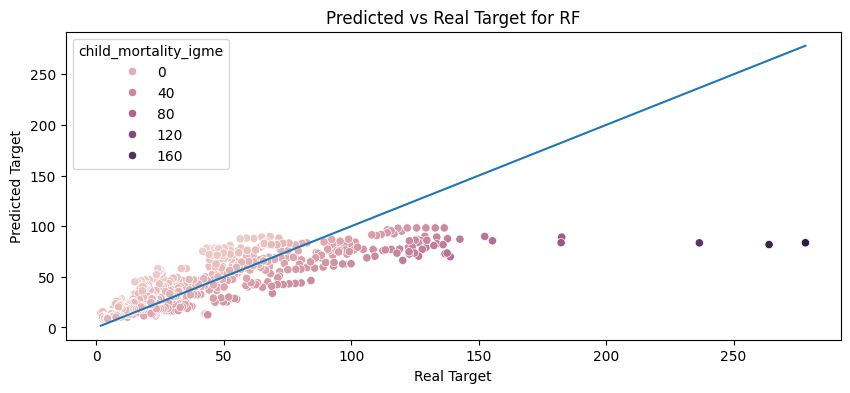

In [103]:
actual_vs_predicted(y_train, rf_y_predicts, rf_residuals, "RF")

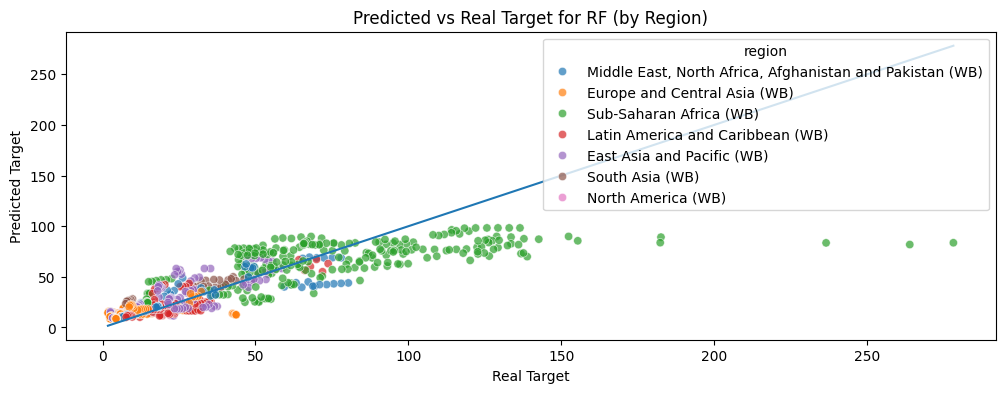

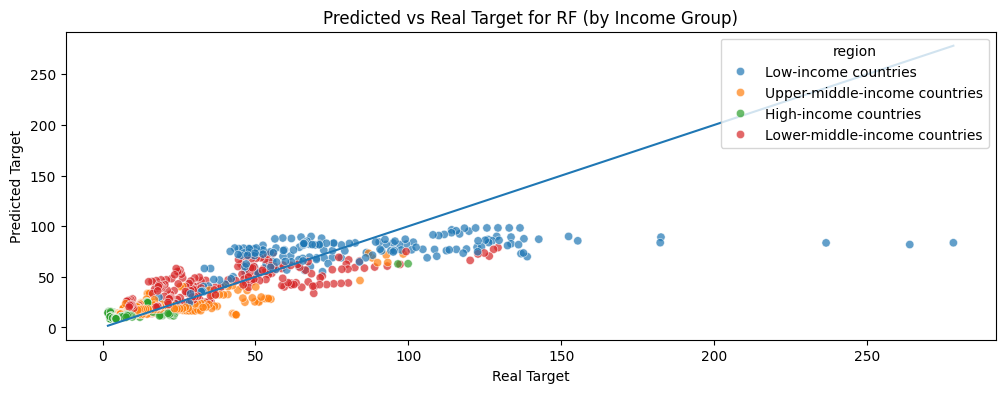

In [105]:
actual_vs_predicted_regions(y_train, rf_y_predicts, rf_residuals, "world_regions_wb", "RF (by Region)")
actual_vs_predicted_regions(y_train, rf_y_predicts, rf_residuals, "world_income_group", "RF (by Income Group)")

In [160]:
rf_feature_pipeline = best_rf_model
pre_pipeline = rf_feature_pipeline.named_steps['preprocess']
#last_transformer = pre_pipeline.steps[-1][1]
feature_names_final = pre_pipeline.get_feature_names_out()
print("Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:")
print(feature_names_final)

Die finalen Feature-Spalten, die dem RF-Modell übergeben wurden:
['nurses_and_midwives_per_1000_people' 'physicians_per_1000_people'
 'prevalence_of_undernourishment' 'share_without_improved_water'
 'vaccination_coverage_who_unicef' 'years_of_schooling'
 'share_of_population_urban' 'healthspending_gdp_ratio'
 'world_regions_wb_East Asia and Pacific (WB)'
 'world_regions_wb_Europe and Central Asia (WB)'
 'world_regions_wb_Latin America and Caribbean (WB)'
 'world_regions_wb_Middle East, North Africa, Afghanistan and Pakistan (WB)'
 'world_regions_wb_North America (WB)' 'world_regions_wb_South Asia (WB)'
 'world_regions_wb_Sub-Saharan Africa (WB)'
 'world_income_group_High-income countries'
 'world_income_group_Low-income countries'
 'world_income_group_Lower-middle-income countries'
 'world_income_group_Upper-middle-income countries']


In [161]:
###Holdout Testset
#best_rf_model.fit(X_train, y_train)

holdout_test(best_rf_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 7.634272196753063, R2: 0.8461252789467206, RMSE: 8.872032918887651
[ 6.62345721  8.84200081 13.18302986 17.25517093]


### XGBoost

In [162]:
# -------------------------------------------------
# XGBOOST
#--------------------------------------------------
xgb_pipeline = Pipeline([
    ("preprocess", end_pipe),
    ("model", XGBRegressor(objective="reg:squarederror", n_jobs=-1, random_state=42))
])
#Target is rightskewed, logtransform y before training
#xgb_pipeline_y_log = TransformedTargetRegressor(
#    regressor=xgb_pipeline,
#    func=np.log1p,
#    inverse_func=np.expm1
#)

xgb_param_grid = {
    "model__n_estimators": [200, 400],
    "model__learning_rate": [0.01, 0.1],
    "model__max_depth": [3, 5],
    "model__min_child_weight": [1, 5],
    "model__subsample": [0.8, 1.0],
    "model__reg_alpha": [0.01, 0.1]
}

xgb_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=gk, scoring=metrics, refit="mae", n_jobs=-1, return_train_score=True)

xgb_search.fit(X_train, y_train, groups=group_train)

show_scores(xgb_search, "XGB")

best_xgb_model = xgb_search.best_estimator_
best_xgb_model


------XGB CV SCORES--------

R2:

Train Folds R2 Scores: [np.float64(0.95), np.float64(0.95), np.float64(0.94), np.float64(0.96)]
            
Mean Train R2 Score: 0.95
            
Test Folds R2 Scores: [np.float64(0.58), np.float64(0.83), np.float64(0.85), np.float64(0.61)]
            
Mean Test R2 Score (best_score_): 0.75)   
            
Std Test R2 Score: 0.13

MAE:

Train Folds MAE Scores: [np.float64(5.23), np.float64(5.42), np.float64(5.36), np.float64(4.51)]
            
Mean Train MAE Score: 5.11
            
Test Folds MAE Scores: [np.float64(11.3), np.float64(7.33), np.float64(6.97), np.float64(15.68)]
            
Mean Test MAE Score: 10.33
            
Std Test MAE Score: 2.81

RMSE:

Train Folds RMSE Scores: [np.float64(8.51), np.float64(8.49), np.float64(8.69), np.float64(6.64)]
            
Mean Train RMSE Score: 8.06
            
Test Folds RMSE Scores: [np.float64(15.89), np.float64(11.28), np.float64(10.09), np.float64(28.97)]
            
Mean Test RMSE Score: 1

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('prep_nums',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_nums',
                                                                   Pipeline(steps=[('knn_impute',
                                                                                    KNNImputer(weights='distance')),
                                                                                   ('log_transform',
                                                                                    FunctionTransformer(feature_names_out='one-to-one',
                                                                                                        func=<ufunc 'log1p'>))]),
                                                                   ['annual_healthcare_expenditure_per_capita',
                                                                    'gdp_per_capita_worldbank...
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=5,
                              missing=nan, monotone_constraints=None,
                              n_estimators=400, n_jobs=-1,
                              num_parallel_tree=None, predictor=None,
                              random_state=42, ...))])

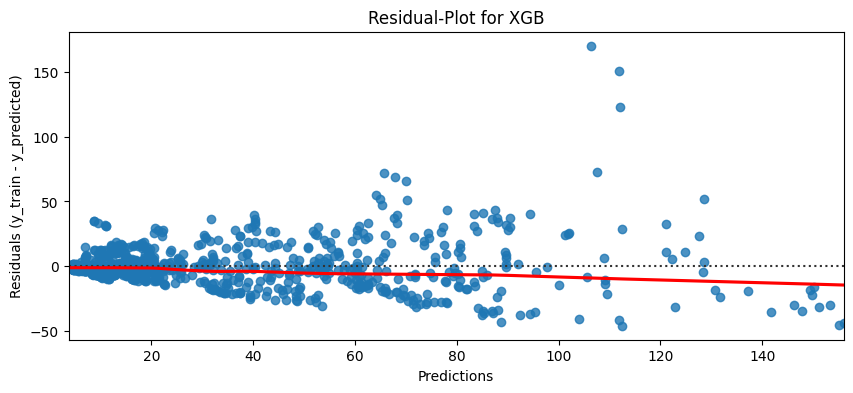

In [163]:
xgb_y_predicts = cross_val_predict(best_xgb_model, X_train, y_train, groups=group_train, cv=gk)
xgb_residuals = y_train - xgb_y_predicts

residual_plot(xgb_y_predicts, xgb_residuals, "XGB")

In [164]:
# Metrics Comparison by Region / Income Group
metrics_per_group(X_train, y_train, xgb_y_predicts, "world_regions_wb")
metrics_per_group(X_train, y_train, xgb_y_predicts, "world_income_group")


Metrics comparison between world_regions_wb:

Middle East, North Africa, Afghanistan and Pakistan (WB) RMSE: 11.8575
Middle East, North Africa, Afghanistan and Pakistan (WB) MAE: 7.4166
Europe and Central Asia (WB) RMSE: 7.5810
Europe and Central Asia (WB) MAE: 4.7416
Sub-Saharan Africa (WB) RMSE: 28.6256
Sub-Saharan Africa (WB) MAE: 20.6207
Latin America and Caribbean (WB) RMSE: 8.5004
Latin America and Caribbean (WB) MAE: 6.0923
East Asia and Pacific (WB) RMSE: 11.3975
East Asia and Pacific (WB) MAE: 8.0306
South Asia (WB) RMSE: 8.6834
South Asia (WB) MAE: 7.1278
North America (WB) RMSE: 2.5185
North America (WB) MAE: 2.5085

Metrics comparison between world_income_group:

Low-income countries RMSE: 30.3862
Low-income countries MAE: 20.0105
Upper-middle-income countries RMSE: 10.4663
Upper-middle-income countries MAE: 7.2278
High-income countries RMSE: 5.1787
High-income countries MAE: 3.4160
Lower-middle-income countries RMSE: 17.1937
Lower-middle-income countries MAE: 13.2909


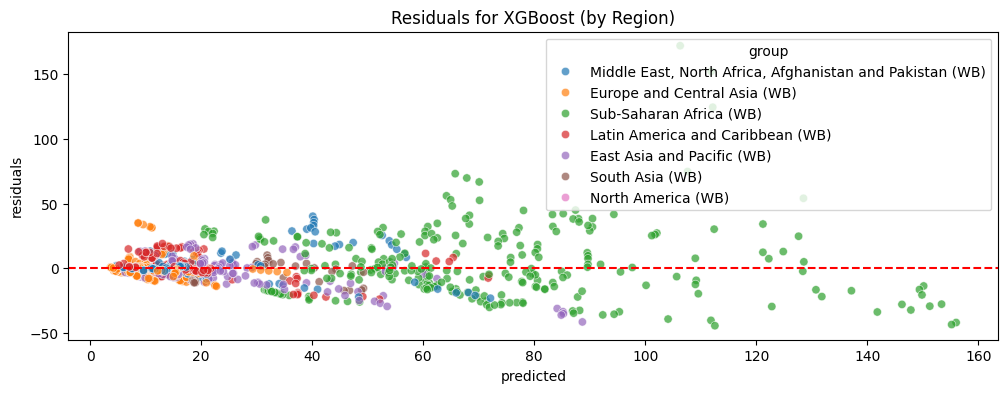

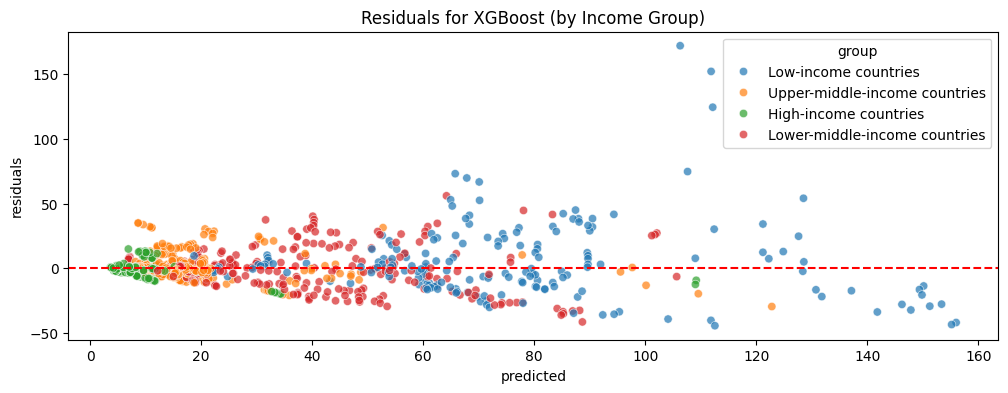

In [166]:
residual_plot_regions(X_train, y_train, xgb_y_predicts, xgb_residuals, "world_regions_wb", "XGBoost (by Region)")
residual_plot_regions(X_train, y_train, xgb_y_predicts, xgb_residuals, "world_income_group", "XGBoost (by Income Group)")

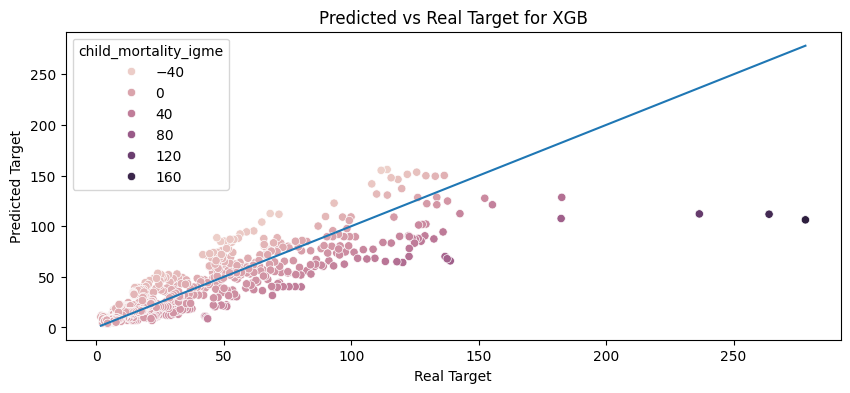

In [167]:
actual_vs_predicted(y_train, xgb_y_predicts, xgb_residuals, "XGB")

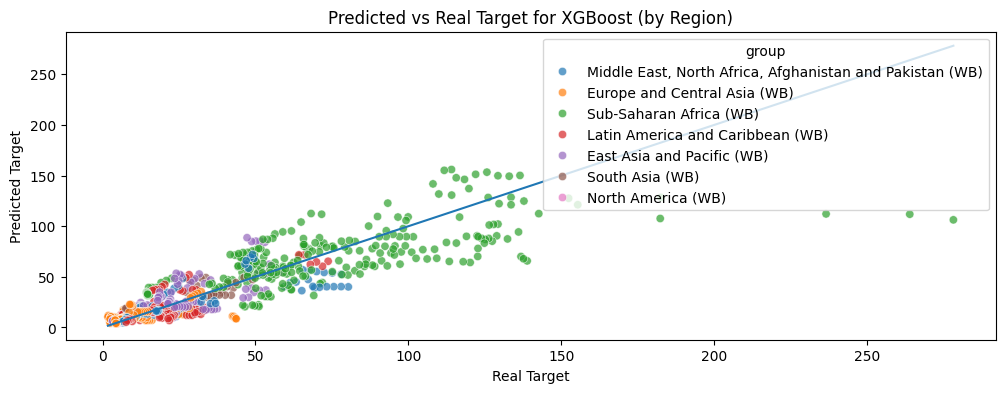

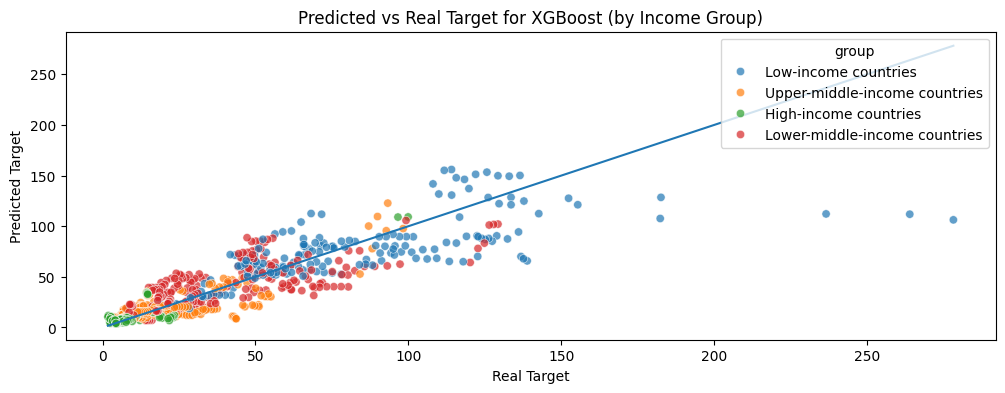

In [168]:
actual_vs_predicted_regions(X_train, y_train, xgb_y_predicts, xgb_residuals, "world_regions_wb", "XGBoost (by Region)")
actual_vs_predicted_regions(X_train, y_train, xgb_y_predicts, xgb_residuals, "world_income_group", "XGBoost (by Income Group)")

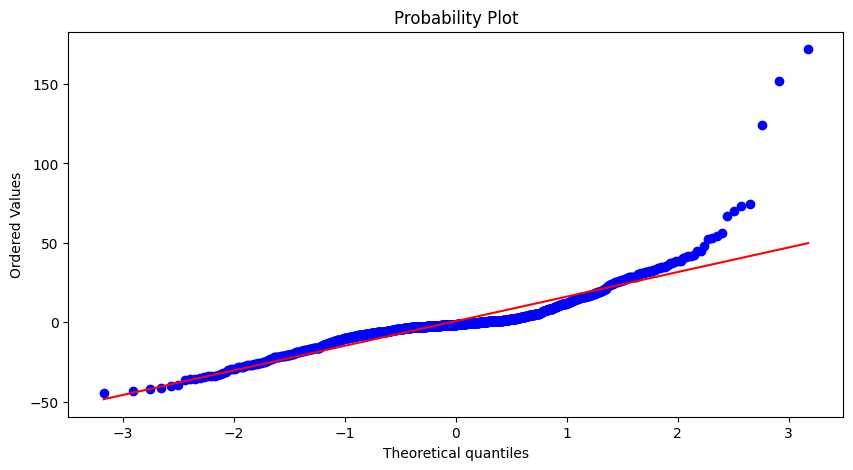

In [169]:
prob_plot(xgb_residuals)

#### Holdout Testset

In [170]:
#Holdout Testset
#best_xgb_model.fit(X_train, y_train)

holdout_test(best_xgb_model, X_test)

----Holdout Testset: Final Metric Scores----
 MAE: 5.299497715420637, R2: 0.89116427852233, RMSE: 7.461484403260112
[ 3.26039427  7.30241732 13.75037441 16.6821811 ]


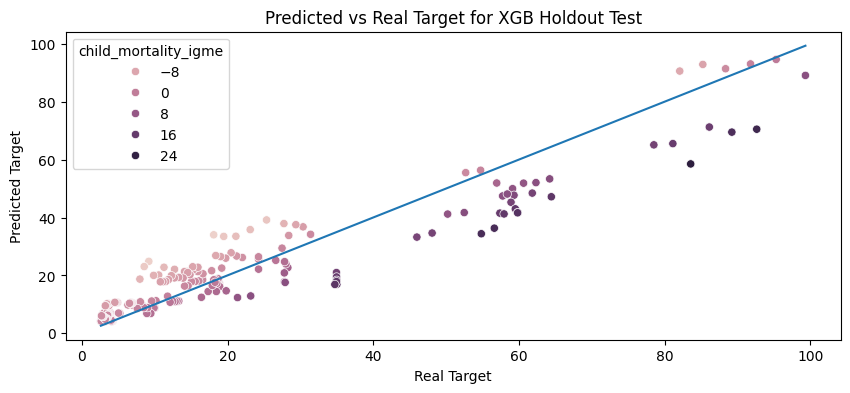

In [116]:
xgb_y_test_predicts = best_xgb_model.predict(X_test)
xgb_test_residuals = y_test - xgb_y_test_predicts

actual_vs_predicted(y_test, xgb_y_test_predicts, xgb_test_residuals, "XGB Holdout Test")

### Extremes (Quantile)

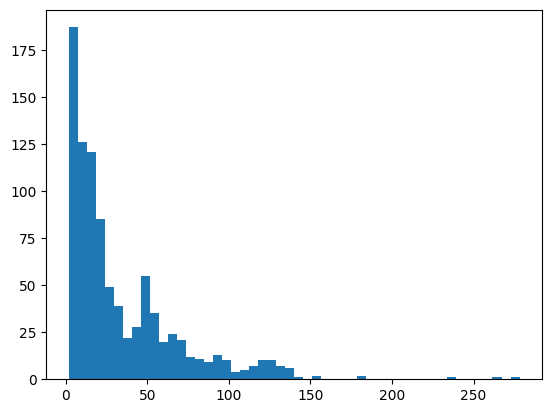

In [517]:
plt.hist(y_train, bins=50)
plt.show()

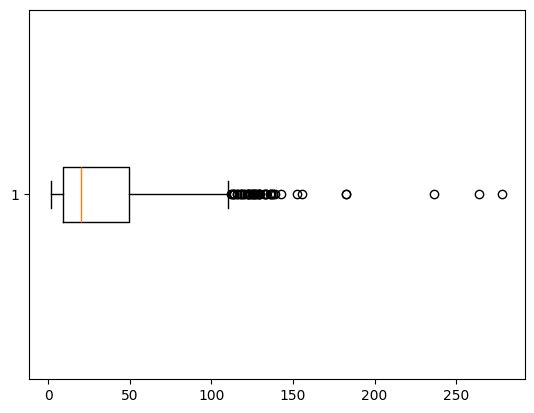

In [518]:
plt.boxplot(y_train, vert=False)
plt.show()

In [42]:
for q in [0.5, 0.70, 0.95]:
    print(f"{q*100:.0f}% Quant:", np.quantile(y_train, q))

qu = 0.95
threshold = np.quantile(y_train, qu)
n_extreme = (y_train > threshold).sum()
print("\nExtremes num:", n_extreme)

50% Quant: 20.0529625
70% Quant: 44.26989699999999
95% Quant: 113.22383799999992

Extremes num: 47


In [579]:
q50 = np.quantile(y_train, 0.5)
print("50%-Quantil (Median):", q50)

50%-Quantil (Median): 20.0529625


In [580]:
n_above_q50 = (y_train > q50).sum()
n_below_q50 = (y_train <= q50).sum()
print("Anzahl über q50:", n_above_q50)
print("Anzahl unter q50:", n_below_q50)

Anzahl über q50: 462
Anzahl unter q50: 462


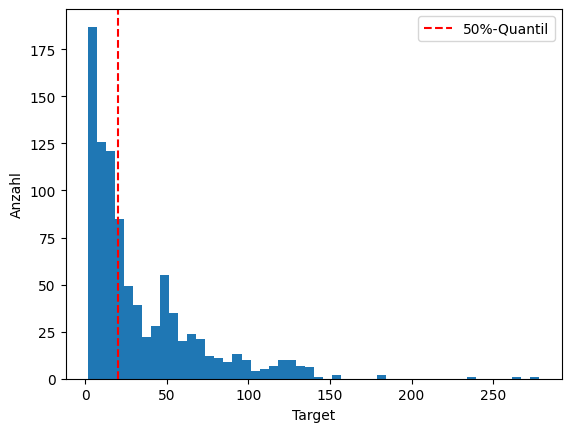

In [581]:
plt.hist(y_train, bins=50)
plt.axvline(q50, color='red', linestyle='--', label='50%-Quantil')
plt.xlabel("Target")
plt.ylabel("Anzahl")
plt.legend()
plt.show()

### Quantile Regression with GradientBoostingRegressor

In [187]:
# -------------------------------------------------
# GradientBoostingRegressor
#--------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

def pinball_scores(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

def coverage_error_metric(y_true, y_pred, quantile):
    actual_coverage = np.mean(y_true <= y_pred)
    return -abs(actual_coverage - quantile)
    
gb_quantiles = [0.25, 0.5, 0.75]
gb_models = {}
gb_cv_results = {}


gb_param_grid = {
    "model__n_estimators": [500, 800],
    "model__max_depth": [2, 4],
    "model__min_samples_leaf": [50, 100],
    "model__learning_rate": [0.01, 0.05, 0.1]
}

for q in gb_quantiles:
    coverage_score = make_scorer(coverage_error_metric, quantile=q)
    print(f"Train for {q}")
    
    gb_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", GradientBoostingRegressor(loss="quantile",alpha=q, n_iter_no_change=10, validation_fraction=0.2, random_state=99))
    ])

    #gb_pipeline_y_log  = TransformedTargetRegressor(
    #    regressor=gb_pipeline,
    #    func=np.log1p,
    #    inverse_func=np.expm1
    #)

    # fit trainset via GridSearchCV
    gb_grid = GridSearchCV(gb_pipeline, gb_param_grid, cv=gk, scoring={"coverage":coverage_score,"pinball":pinball_scores(q)}, 
                           refit="pinball", return_train_score=True, n_jobs=-1)
    gb_grid.fit(X_train, y_train, groups=group_train)

    gb_models[q] = gb_grid.best_estimator_
    #gb_models[q]
    print("Best params:", gb_grid.best_params_)
    #gb_results = pd.DataFrame(gb_grid.cv_results_)

Train for 0.25
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__min_samples_leaf': 50, 'model__n_estimators': 500}
Train for 0.5
Best params: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__min_samples_leaf': 50, 'model__n_estimators': 800}
Train for 0.75
Best params: {'model__learning_rate': 0.01, 'model__max_depth': 2, 'model__min_samples_leaf': 50, 'model__n_estimators': 800}


Coverage: 0.31385281385281383
Above diagonal: 0.6861471861471862
Below diagonal: 0.31385281385281383

Trainset: Quantile 0.25, Pinball Loss: 3.9550

mean=3.9550, std=0.8807
MAE: 12.7832, std=3.178766831482479 R2: 0.5693, std=0.1112

Coverage: 0.5183982683982684
Above diagonal: 0.4816017316017316
Below diagonal: 0.5183982683982684

Trainset: Quantile 0.5, Pinball Loss: 5.3126

mean=5.3126, std=1.6016
MAE: 10.6253, std=3.203197152844775 R2: 0.7304, std=0.1296

Coverage: 0.7164502164502164
Above diagonal: 0.28354978354978355
Below diagonal: 0.7164502164502164

Trainset: Quantile 0.75, Pinball Loss: 4.8815

mean=4.8815, std=1.7607
MAE: 11.5414, std=3.324818625840574 R2: 0.7254, std=0.1634



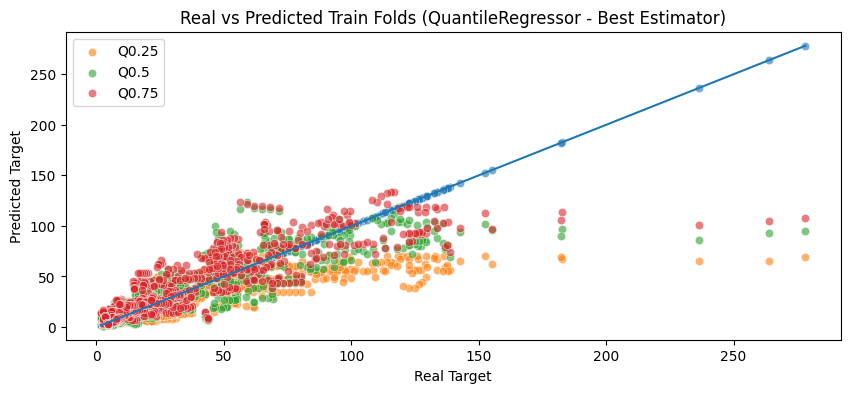

In [188]:
gb_y_pred_train = {}  
gb_residuals = {}
#Residuals & pinball mean losses
for q, model in gb_models.items():
    gb_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    gb_residuals[q] = y_train - gb_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= gb_y_pred_train[q]))
    print("Above diagonal:", np.mean(y_train > gb_y_pred_train[q]))
    print("Below diagonal:", np.mean(y_train < gb_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, gb_y_pred_train[q], alpha=q)
    print(f"\nTrainset: Quantile {q}, Pinball Loss: {loss:.4f}\n")

    #pinball score + std
    gb_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    gb_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=gb_scorer)
    print(f"mean={-gb_scores.mean():.4f}, std={gb_scores.std():.4f}")
    #mae + r2 Zusatz
    gb_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    gb_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-gb_mae_scores.mean():.4f}, std={gb_mae_scores.std()} R2: {gb_r2_scores.mean():.4f}, std={gb_r2_scores.std():.4f}\n")

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_train, y=gb_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

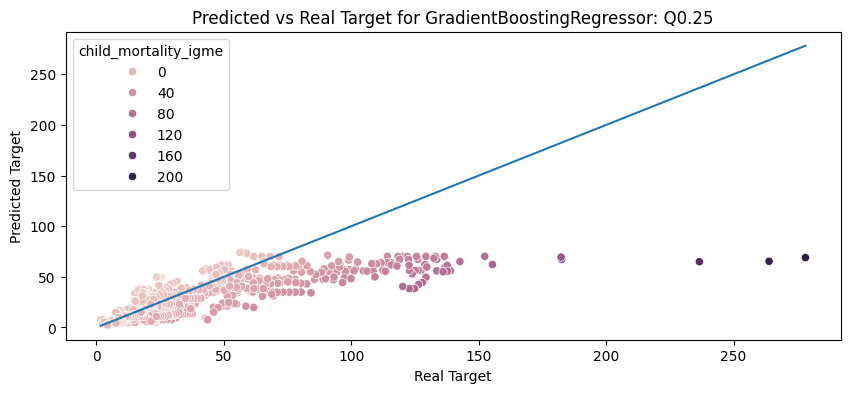

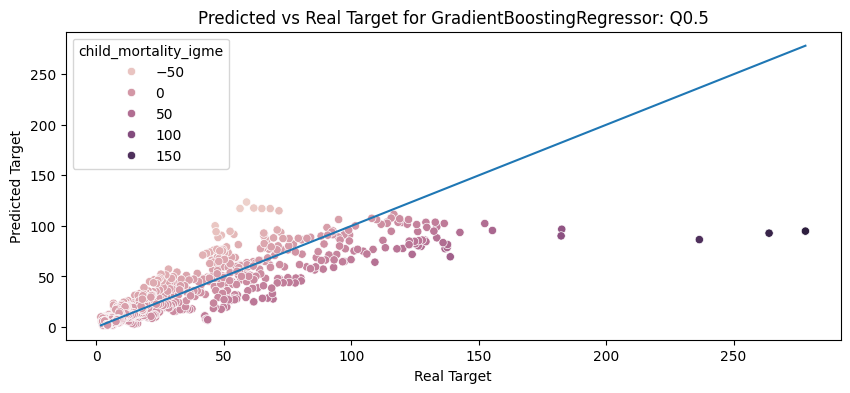

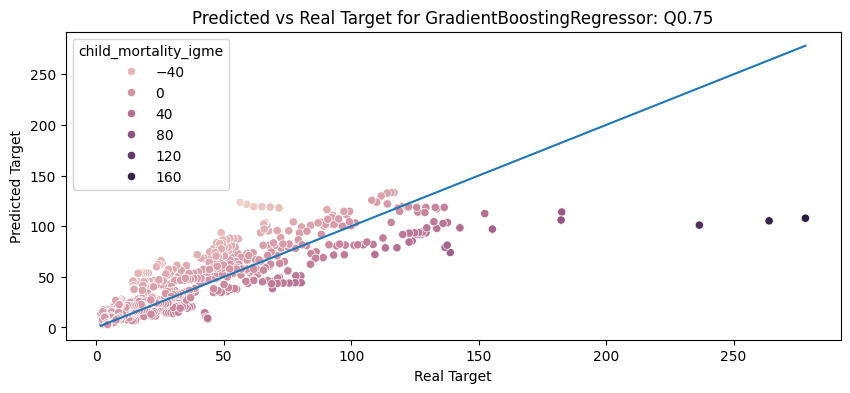

In [189]:
actual_vs_predicted(y_train, gb_y_pred_train[0.25], gb_residuals[0.25], f"GradientBoostingRegressor: Q{0.25}")
actual_vs_predicted(y_train, gb_y_pred_train[0.5], gb_residuals[0.5], f"GradientBoostingRegressor: Q{0.5}")
actual_vs_predicted(y_train, gb_y_pred_train[0.75], gb_residuals[0.75], f"GradientBoostingRegressor: Q{0.75}")

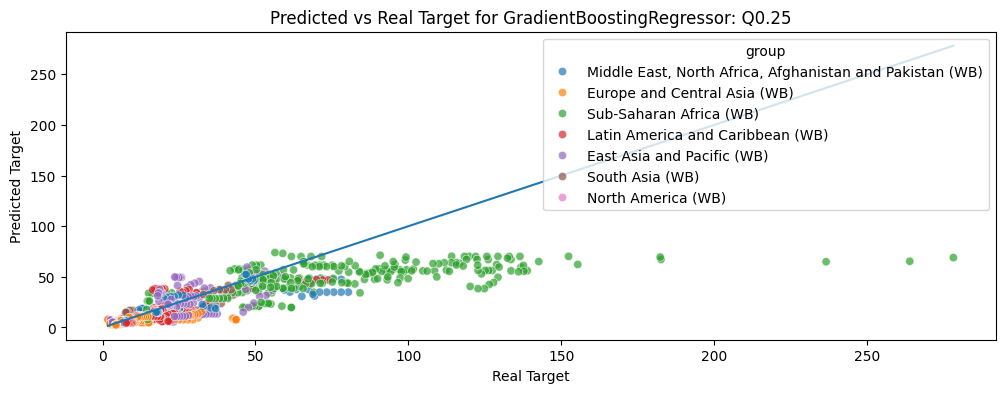

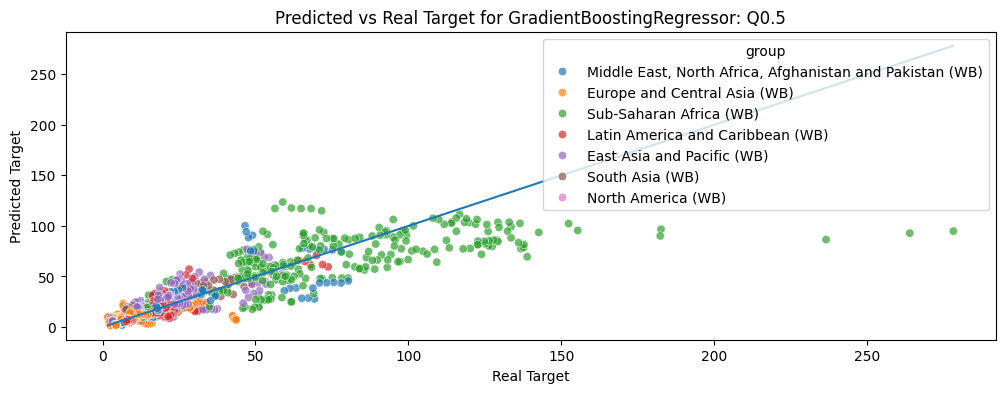

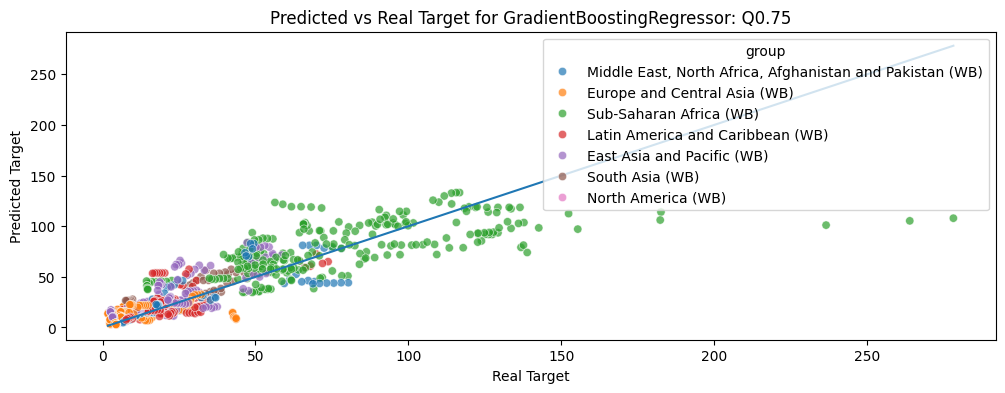

In [190]:
actual_vs_predicted_regions(X_train, y_train, gb_y_pred_train[0.25], gb_residuals[0.25], "world_regions_wb", f"GradientBoostingRegressor: Q{0.25}")
actual_vs_predicted_regions(X_train, y_train, gb_y_pred_train[0.5], gb_residuals[0.5], "world_regions_wb", f"GradientBoostingRegressor: Q{0.5}")
actual_vs_predicted_regions(X_train, y_train, gb_y_pred_train[0.75], gb_residuals[0.75], "world_regions_wb", f"GradientBoostingRegressor: Q{0.75}")

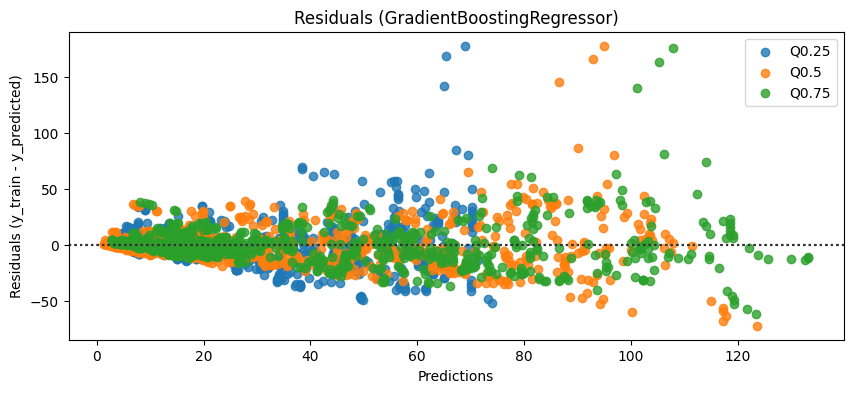

In [191]:
plt.figure(figsize=(10,4))
for q in gb_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=gb_y_pred_train[q], y=gb_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (GradientBoostingRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

#### Holdout Test

In [192]:
gb_y_pred_test = {}
gb_test_residuals = {}
for q, model in gb_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    gb_y_pred_test[q] = model.predict(X_test)

    gb_test_residuals[q] = y_test - gb_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= gb_y_pred_test[q]))
    print("Above:", np.mean(y_test > gb_y_pred_test[q]))
    print("Below:", np.mean(y_test < gb_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, gb_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, gb_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.33760683760683763
Above: 0.6623931623931624
Below: 0.33760683760683763

Quantile 0.25, Pinball Loss: 2.4005

Coverage: 0.4700854700854701
Above: 0.5299145299145299
Below: 0.4700854700854701

Quantile 0.5, Pinball Loss: 2.8028

Coverage: 0.7649572649572649
Above: 0.23504273504273504
Below: 0.7649572649572649

Quantile 0.75, Pinball Loss: 2.0554


Q0.5 MAE: 5.605633689381121


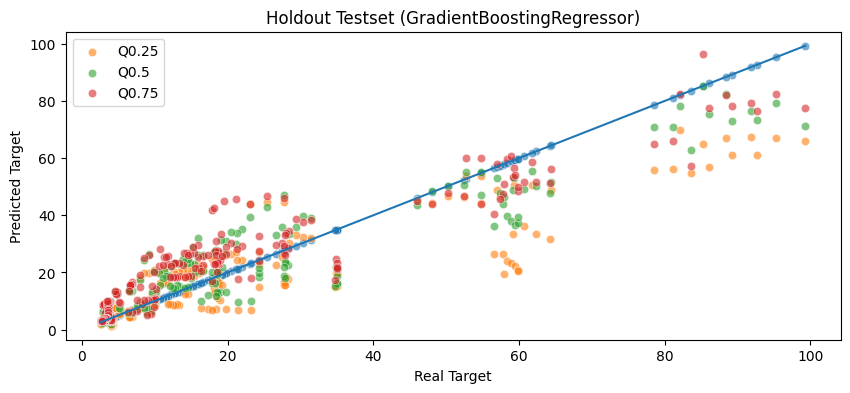

In [77]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in gb_quantiles:
    sns.scatterplot(x=y_test, y=gb_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (GradientBoostingRegressor)")
plt.legend()
plt.show()

### Quantile Regression with QuantileRegressor

In [171]:
# -------------------------------------------------
# QuantileRegressor
#--------------------------------------------------
#https://xgboosting.com/xgboost-prediction-interval-using-quantile-regression/
from sklearn.linear_model import QuantileRegressor
from joblib import dump, load

qr_quantiles = [0.25, 0.5, 0.75]
qr_models = {}
cv_results = {}

def pinball_scoring(a):
    return make_scorer(
        mean_pinball_loss,
        alpha=a,
        greater_is_better=False
    )

def coverage_error_metric(y_true, y_pred, quantile):
    actual_coverage = np.mean(y_true <= y_pred)
    return -abs(actual_coverage - quantile)

qr_param_grid = {
    #"regressor__model__alpha": [0.01, 0.05, 0.1, 0.5, 1]
    "model__alpha": [0.01, 0.05, 0.1, 0.5, 1]
}

for q in qr_quantiles:
    print(f"Train for {q}")
    coverage_score = make_scorer(coverage_error_metric, quantile=q)
    
    qr_pipeline = Pipeline([
        ("preprocess", end_pipe),
        ("model", QuantileRegressor(quantile=q))
    ])

    #qr_pipeline_y_log = TransformedTargetRegressor(
    #    regressor=qr_pipeline,
    #    func=np.log1p,
    #    inverse_func=np.expm1
    #)

    # fit trainset via GridSearchCV
    qr_grid = GridSearchCV(qr_pipeline, qr_param_grid, cv=gk, scoring={"coverage":coverage_score,"pinball":pinball_scoring(q)}, 
                           refit="pinball", return_train_score=True, n_jobs=-1)
    qr_grid.fit(X_train, y_train, groups=group_train)

    qr_models[q] = qr_grid.best_estimator_
    print("Best params:", qr_grid.best_params_)
#qr_grid.best_estimator_
    #gb_results = pd.DataFrame(gb_grid.cv_results_)
    #print(gb_results[["params", "mean_test_score", "rank_test_score"]])

Train for 0.25
Best params: {'model__alpha': 0.01}
Train for 0.5
Best params: {'model__alpha': 0.01}
Train for 0.75
Best params: {'model__alpha': 0.01}


#### Train Folds Performance per Q

Coverage: 0.2846320346320346
Above: 0.7153679653679653
Below: 0.2846320346320346

Folds CV: Quantile 0.25, Folds Mean Pinball Loss: 3.9430
mean=3.9430, std=0.7143
MAE: 13.0215, std=3.1207895136988393 R2: 0.5694, std=0.1186

Coverage: 0.5183982683982684
Above: 0.4816017316017316
Below: 0.5183982683982684

Folds CV: Quantile 0.5, Folds Mean Pinball Loss: 5.8897
mean=5.8897, std=1.3243
MAE: 11.7795, std=2.648570684744726 R2: 0.6942, std=0.1023

Coverage: 0.7218614718614719
Above: 0.27813852813852813
Below: 0.7218614718614719

Folds CV: Quantile 0.75, Folds Mean Pinball Loss: 5.1401
mean=5.1401, std=1.5184
MAE: 13.6297, std=2.8053985357826083 R2: 0.6521, std=0.1525



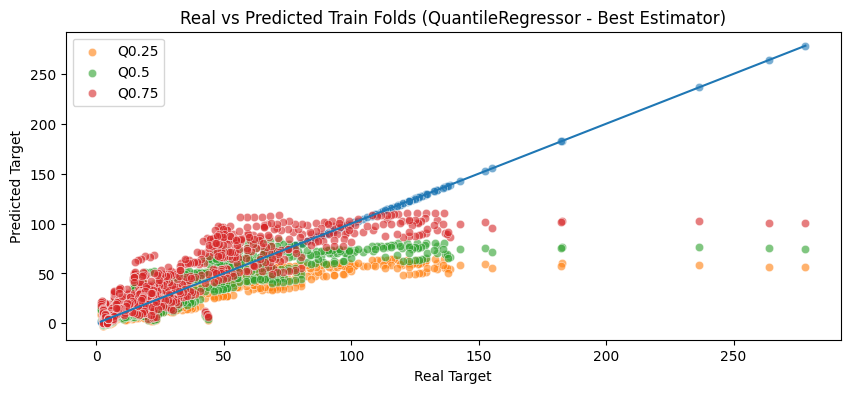

In [183]:
#qr_y_training_pred= {}

qr_y_pred_train = {}  
qr_residuals = {}
#Residuals & pinball mean losses
for q, model in qr_models.items():
    qr_y_pred_train[q] = cross_val_predict(model, X_train, y_train, groups=group_train, cv=gk)
    qr_residuals[q] = y_train - qr_y_pred_train[q]
    print("Coverage:", np.mean(y_train <= qr_y_pred_train[q]))
    print("Above:", np.mean(y_train > qr_y_pred_train[q]))
    print("Below:", np.mean(y_train < qr_y_pred_train[q]))

    loss = mean_pinball_loss(y_train, qr_y_pred_train[q], alpha=q)
    print(f"\nFolds CV: Quantile {q}, Folds Mean Pinball Loss: {loss:.4f}")

    #pinball score + std
    qr_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=q)
    qr_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring=qr_scorer)
    print(f"mean={-qr_scores.mean():.4f}, std={qr_scores.std():.4f}")
    #mae + r2 Zusatz
    qr_mae_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="neg_mean_absolute_error")
    qr_r2_scores = cross_val_score(model, X_train, y_train, cv=gk, groups=group_train, scoring="r2")
    print(f"MAE: {-qr_mae_scores.mean():.4f}, std={qr_mae_scores.std()} R2: {qr_r2_scores.mean():.4f}, std={qr_r2_scores.std():.4f}\n")
    #print("Fold MAE Scores": qr_mae_scores)

    # Metrics Comparison by Region / Income Group
    #metrics_per_group(X_train, y_train, qr_y_pred_train[q], "world_regions_wb")
    #metrics_per_group(X_train, y_train, qr_y_pred_train[q], "world_income_group")

#Real vs Predicted Scatterplots
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_train, y=y_train, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_train, y=qr_y_pred_train[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Real vs Predicted Train Folds (QuantileRegressor - Best Estimator)")
plt.legend()
plt.show()

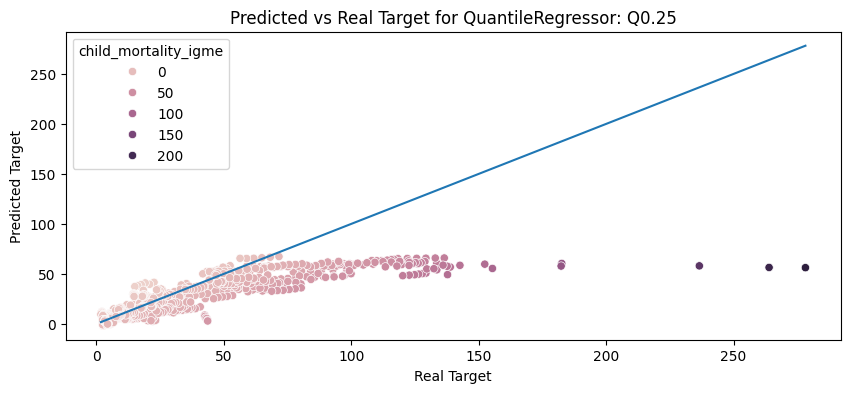

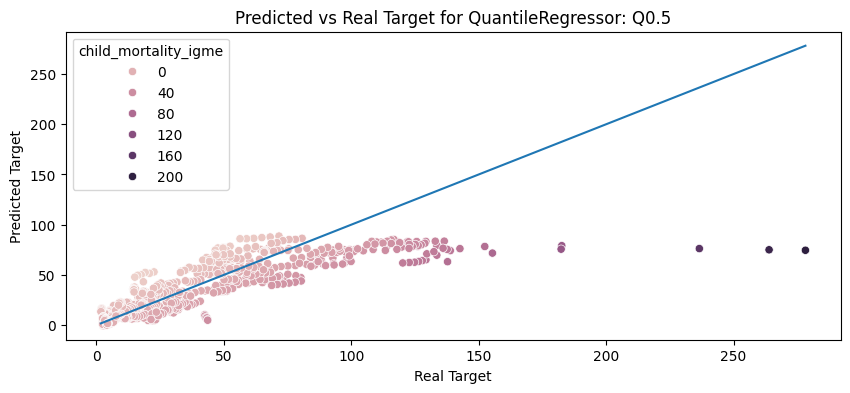

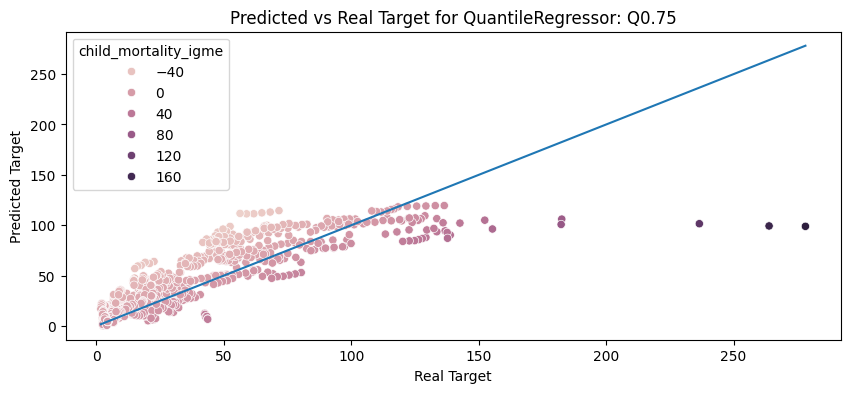

In [109]:
actual_vs_predicted(y_train, qr_y_pred_train[0.25], qr_residuals[0.25], f"QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_train, qr_y_pred_train[0.5], qr_residuals[0.5], f"QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_train, qr_y_pred_train[0.75], qr_residuals[0.75], f"QuantileRegressor: Q{0.75}")

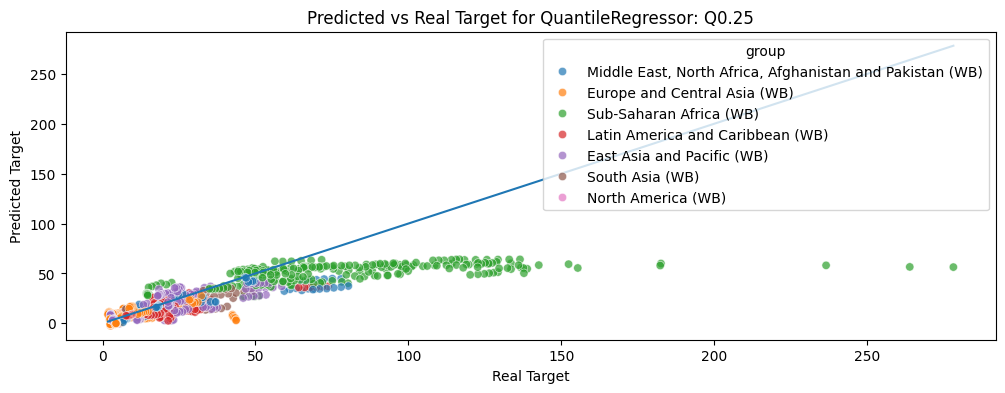

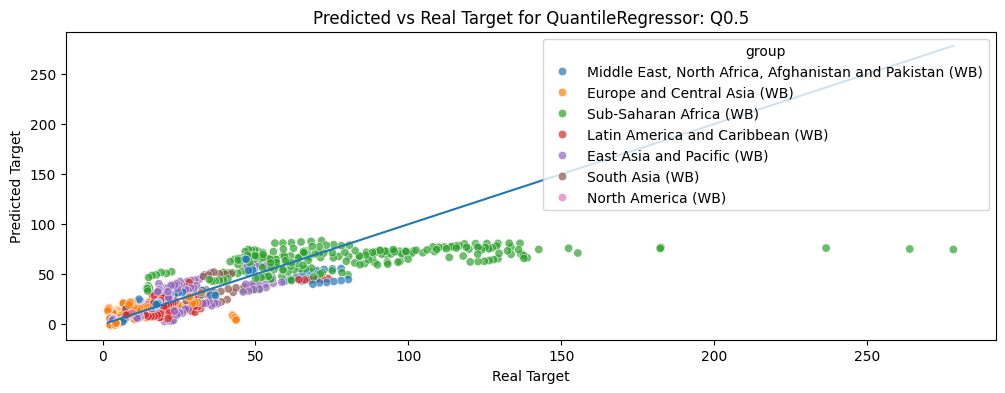

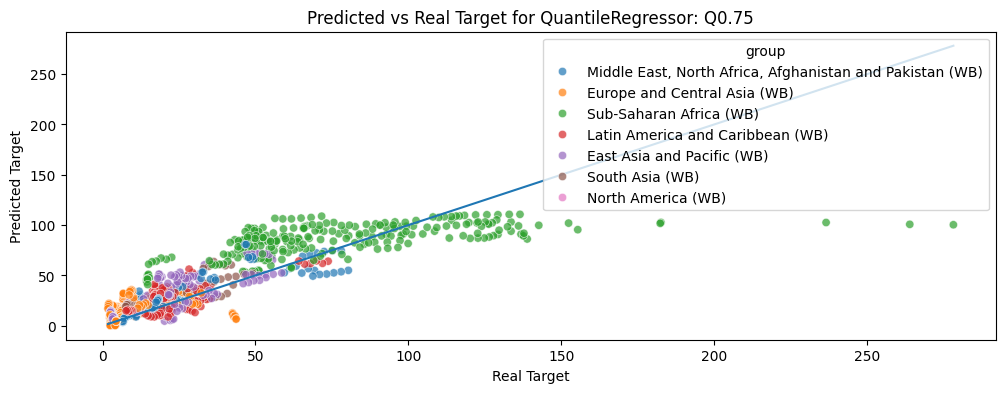

In [174]:
actual_vs_predicted_regions(X_train, y_train, qr_y_pred_train[0.25], qr_residuals[0.25], "world_regions_wb", f"QuantileRegressor: Q{0.25}")
actual_vs_predicted_regions(X_train, y_train, qr_y_pred_train[0.5], qr_residuals[0.5], "world_regions_wb", f"QuantileRegressor: Q{0.5}")
actual_vs_predicted_regions(X_train, y_train, qr_y_pred_train[0.75], qr_residuals[0.75], "world_regions_wb", f"QuantileRegressor: Q{0.75}")

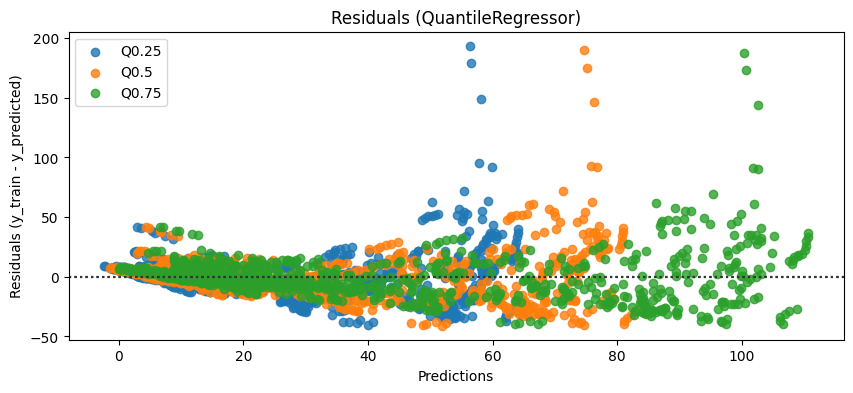

In [175]:
plt.figure(figsize=(10,4))
for q in qr_quantiles:
    #residual_plot(qr_y_pred_train[q], qr_residuals[q], f"Q{q}")
    sns.residplot(x=qr_y_pred_train[q], y=qr_residuals[q], label=f'Q{q}')
plt.title(f"Residuals (QuantileRegressor)")
plt.xlabel("Predictions")
plt.ylabel("Residuals (y_train - y_predicted)")
plt.legend()
plt.show()

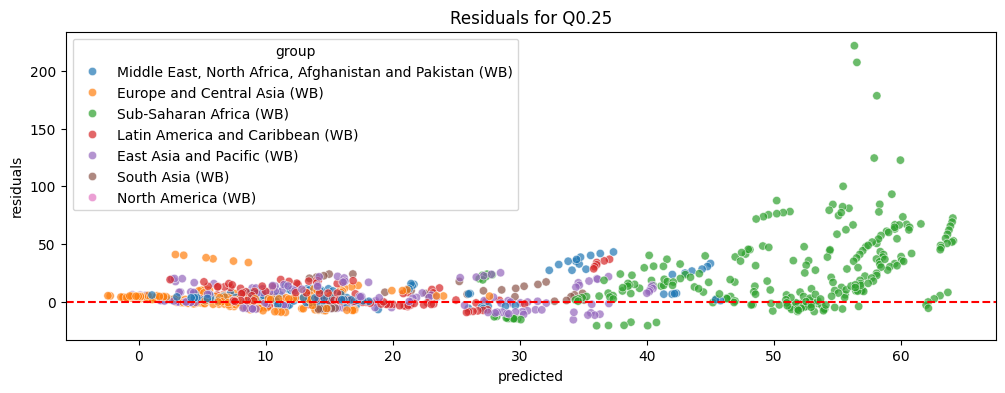

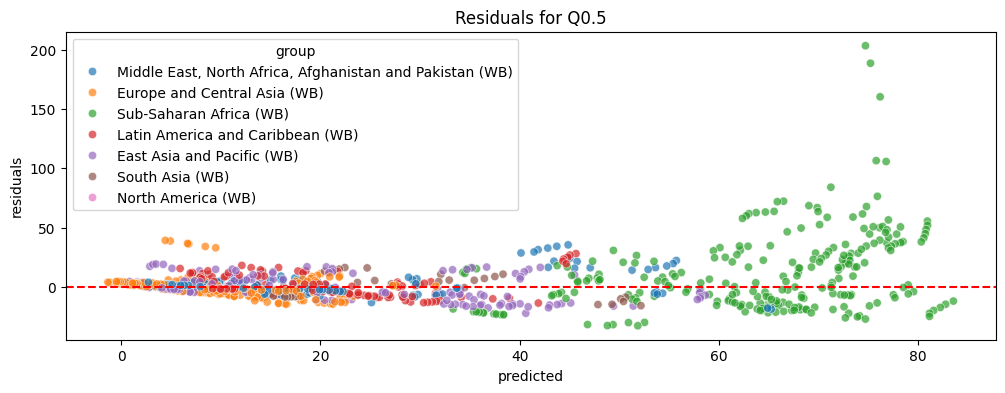

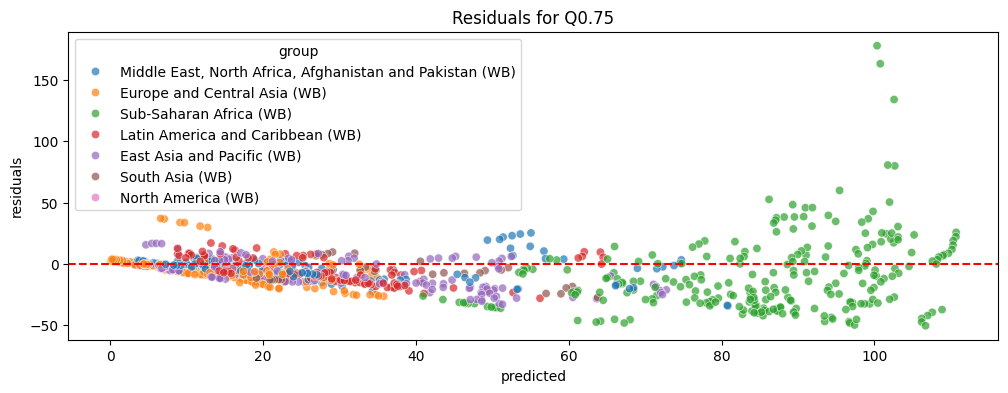

In [176]:
residual_plot_regions(X_train, y_train, qr_y_pred_train[0.25], qr_residuals[0.25], "world_regions_wb", f"Q{0.25}")
#residual_plot(qr_y_pred_train[0.5], qr_residuals[0.5], f"Q{0.5}")
residual_plot_regions(X_train, y_train, qr_y_pred_train[0.5], qr_residuals[0.5], "world_regions_wb", f"Q{0.5}")
residual_plot_regions(X_train, y_train, qr_y_pred_train[0.75], qr_residuals[0.75], "world_regions_wb", f"Q{0.75}")

In [177]:
qr_results = pd.DataFrame(qr_grid.cv_results_)
qr_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.316934      0.011281         0.071803        0.008135   
1       0.283786      0.015936         0.062251        0.007592   
2       0.291269      0.021598         0.067894        0.007941   
3       0.245872      0.013376         0.065726        0.009413   
4       0.216896      0.020095         0.052268        0.007042   

   param_model__alpha                  params  split0_test_coverage  \
0                0.01  {'model__alpha': 0.01}             -0.007576   
1                0.05  {'model__alpha': 0.05}             -0.030303   
2                0.10   {'model__alpha': 0.1}             -0.045455   
3                0.50   {'model__alpha': 0.5}             -0.037879   
4                1.00     {'model__alpha': 1}             -0.037879   

   split1_test_coverage  split2_test_coverage  split3_test_coverage  \
0             -0.030303             -0.098485             -0.068182   
1             -0.045455             -0.007576             -0.030303   
2             -0.007576             -0.045455             -0.022727   
3             -0.068182             -0.075758             -0.053030   
4             -0.068182             -0.075758             -0.053030   

   split4_test_coverage  split5_test_coverage  split6_test_coverage  \
0             -0.068182             -0.045455             -0.075758   
1             -0.090909             -0.022727             -0.075758   
2             -0.151515             -0.037879             -0.106061   
3             -0.022727             -0.015152             -0.075758   
4             -0.022727             -0.015152             -0.075758   

   mean_test_coverage  std_test_coverage  rank_test_coverage  \
0           -0.056277           0.028305                   4   
1           -0.043290           0.027677                   1   
2           -0.059524           0.047125                   5   
3           -0.049784           0.023212                   2   
4           -0.049784           0.023212                   2   

   split0_train_coverage  split1_train_coverage  split2_train_coverage  \
0              -0.006313              -0.002525              -0.006313   
1              -0.001263              -0.003788              -0.001263   
2              -0.000000              -0.003788              -0.001263   
3              -0.000000              -0.000000              -0.000000   
4              -0.000000              -0.000000              -0.000000   

   split3_train_coverage  split4_train_coverage  split5_train_coverage  \
0              -0.002525              -0.001263              -0.003788   
1              -0.001263              -0.003788              -0.002525   
2              -0.000000              -0.001263              -0.002525   
3              -0.000000              -0.000000              -0.000000   
4              -0.000000              -0.000000              -0.000000   

   split6_train_coverage  mean_train_coverage  std_train_coverage  \
0              -0.003788            -0.003788            0.001786   
1              -0.001263            -0.002165            0.001112   
2              -0.002525            -0.001623            0.001301   
3              -0.000000             0.000000            0.000000   
4              -0.000000             0.000000            0.000000   

   split0_test_pinball  split1_test_pinball  split2_test_pinball  \
0            -4.791180            -2.743821            -4.092950   
1            -4.575496            -3.243436            -3.280677   
2            -5.122393            -4.532492            -3.956566   
3            -9.298203           -10.369287            -9.883739   
4            -9.298203           -10.369287            -9.883739   

   split3_test_pinball  split4_test_pinball  split5_test_pinball  \
0            -7.633394            -5.132950            -4.766278   
1            -8.526610            -6.325600            -6.043234   
2            -9.

#### SHAP Explanations

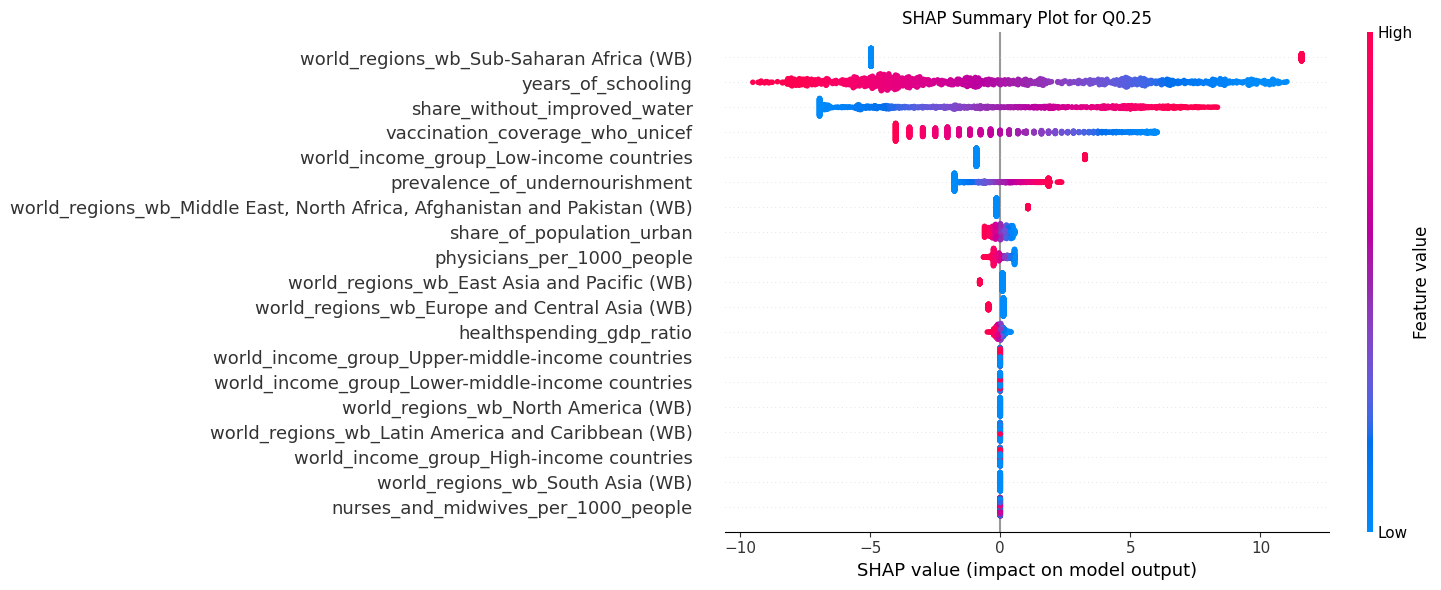

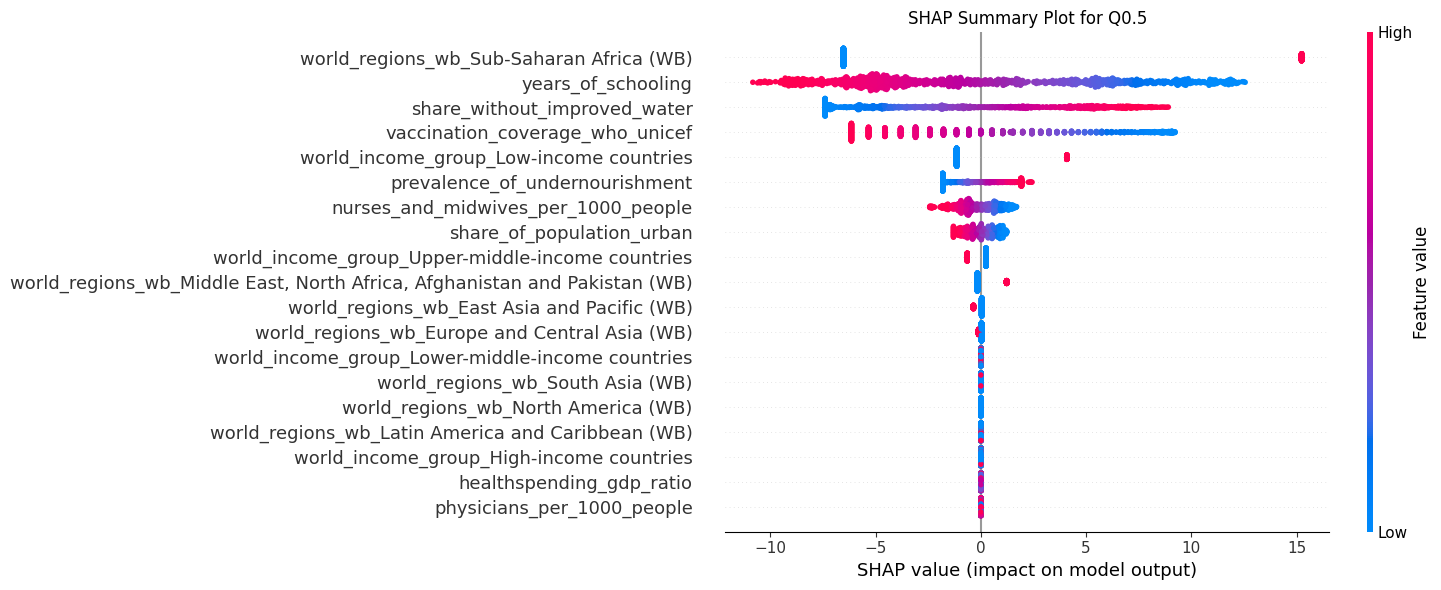

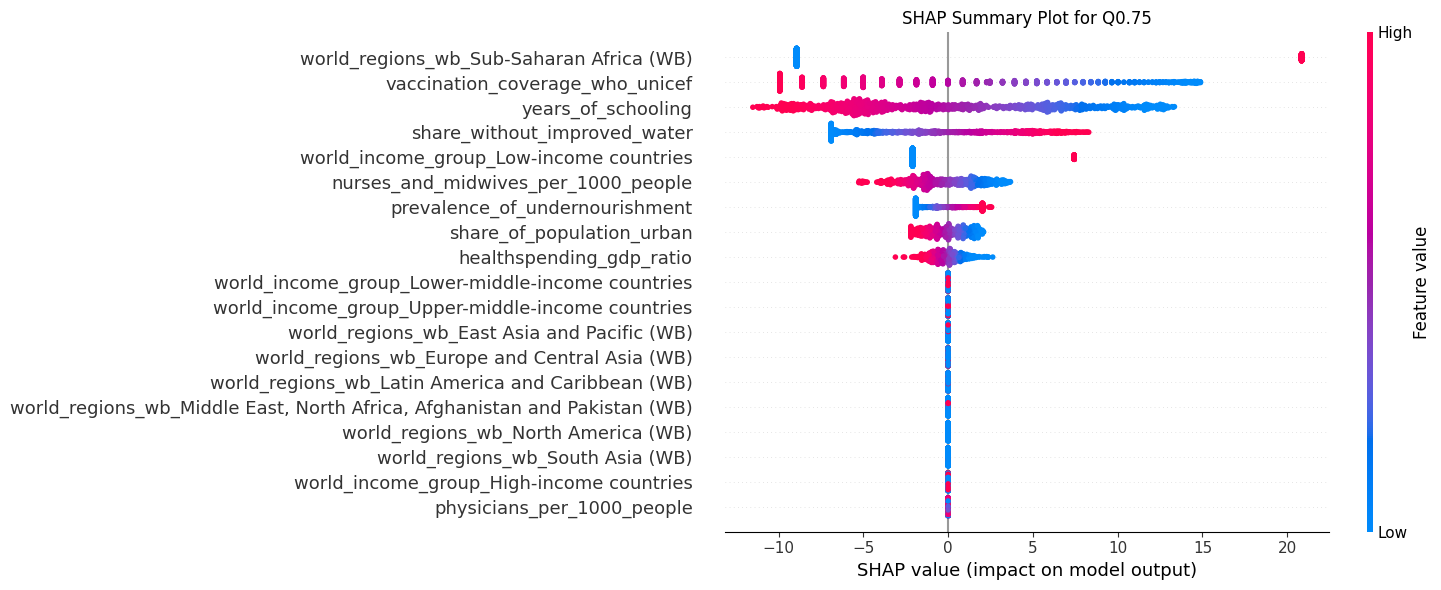

In [164]:
import shap
rng = np.random.default_rng(seed=42)

for q, model in qr_models.items():
    #qr_pipeline = model.regressor_
    qr_pre = model.named_steps["preprocess"]
    qr_model = model.named_steps["model"]

    X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    #shap.plots.waterfall(shapvals[0]) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Holdout Testset

In [185]:
qr_y_pred_test = {}
qr_test_residuals = {}
for q, model in qr_models.items():
    #model.fit(X_train, y_train)
    #holdout_test(model, X_test)
    qr_y_pred_test[q] = model.predict(X_test)

    qr_test_residuals[q] = y_test - qr_y_pred_test[q]
    print("Coverage:", np.mean(y_test <= qr_y_pred_test[q]))
    print("Above:", np.mean(y_test > qr_y_pred_test[q]))
    print("Below:", np.mean(y_test < qr_y_pred_test[q]))

    loss = mean_pinball_loss(y_test, qr_y_pred_test[q], alpha=q)
    print(f"\nQuantile {q}, Pinball Loss: {loss:.4f}\n")

#mae_025 = mean_absolute_error(y_test, qr_y_pred_test[0.25])
mae_05 = mean_absolute_error(y_test, qr_y_pred_test[0.5])
#mae_075 = mean_absolute_error(y_test, qr_y_pred_test[0.75])
print(f"\nQ0.5 MAE: {mae_05}")

Coverage: 0.29914529914529914
Above: 0.7008547008547008
Below: 0.29914529914529914

Quantile 0.25, Pinball Loss: 2.5490

Coverage: 0.5427350427350427
Above: 0.45726495726495725
Below: 0.5427350427350427

Quantile 0.5, Pinball Loss: 3.2613

Coverage: 0.7948717948717948
Above: 0.20512820512820512
Below: 0.7948717948717948

Quantile 0.75, Pinball Loss: 2.9201


Q0.5 MAE: 6.5226848105813575


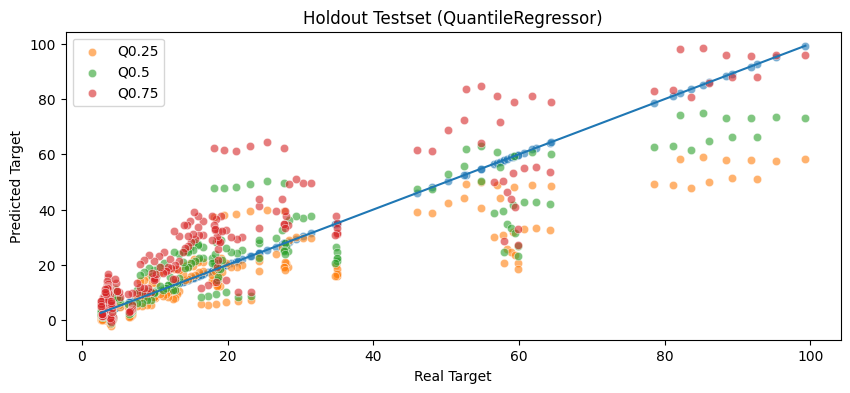

In [179]:
plt.figure(figsize=(10,4))
sns.scatterplot(x=y_test, y=y_test, alpha=0.6)  
for q in qr_quantiles:
    sns.scatterplot(x=y_test, y=qr_y_pred_test[q], label=f'Q{q}', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.xlabel("Real Target")
plt.ylabel("Predicted Target")
plt.title("Holdout Testset (QuantileRegressor)")
plt.legend()
plt.show()

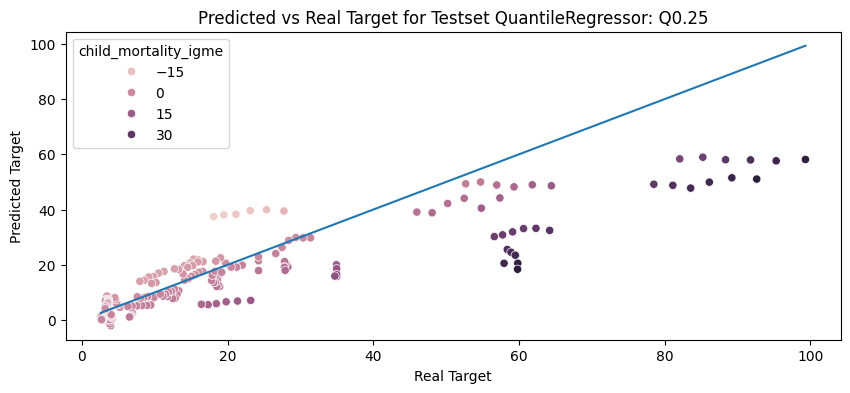

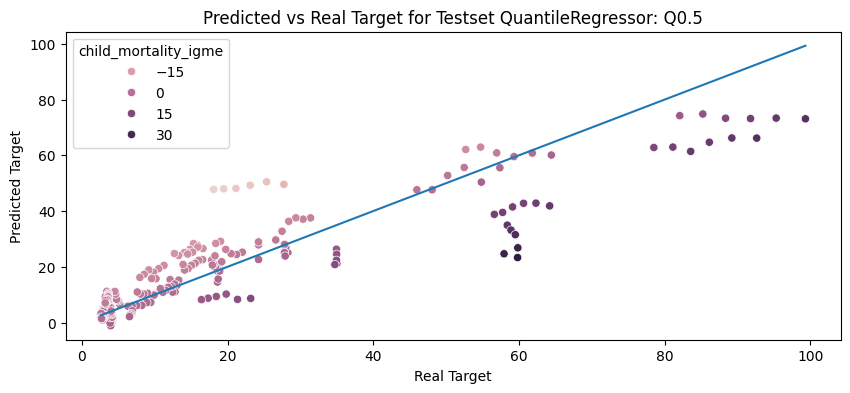

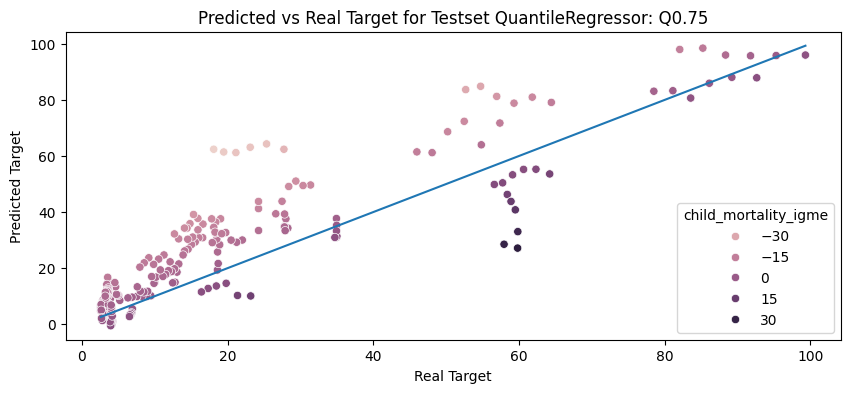

In [180]:
actual_vs_predicted(y_test, qr_y_pred_test[0.25], qr_test_residuals[0.25], f"Testset QuantileRegressor: Q{0.25}")
actual_vs_predicted(y_test, qr_y_pred_test[0.5], qr_test_residuals[0.5], f"Testset QuantileRegressor: Q{0.5}")
actual_vs_predicted(y_test, qr_y_pred_test[0.75], qr_test_residuals[0.75], f"Testset QuantileRegressor: Q{0.75}")

#### SHAP Tests

In [134]:
#Test new data sample 
bangladesh_new = [{'Entity': 'Bangladesh', 'annual_healthcare_expenditure_per_capita': 120, 'gdp_per_capita_worldbank': 3000, 'nurses_and_midwives_per_1000_people': 10.5, 'physicians_per_1000_people': 0.5, 'prevalence_of_undernourishment': 20.8, 'share_of_population_urban': 16, 'share_without_improved_water': 80.2, 'vaccination_coverage_who_unicef': 98, 'years_of_schooling': 2, 'world_regions_wb': 'South Asia (WB)', 'world_income_group': 'Lower-middle-income countries'}]
bangladesh_df = pd.DataFrame(bangladesh_new)

In [135]:
qr_y_pred_test_bang = {}
qr_test_residuals_bang = {}
for q, model in qr_models.items():

    qr_y_pred_test_bang[q] = model.predict(bangladesh_df)
print(qr_y_pred_test_bang)


{0.25: array([43.52937209]), 0.5: array([47.7911293]), 0.75: array([57.08634841])}


In [136]:
qr_y_pred_test_bang[0.25]

array([43.52937209])

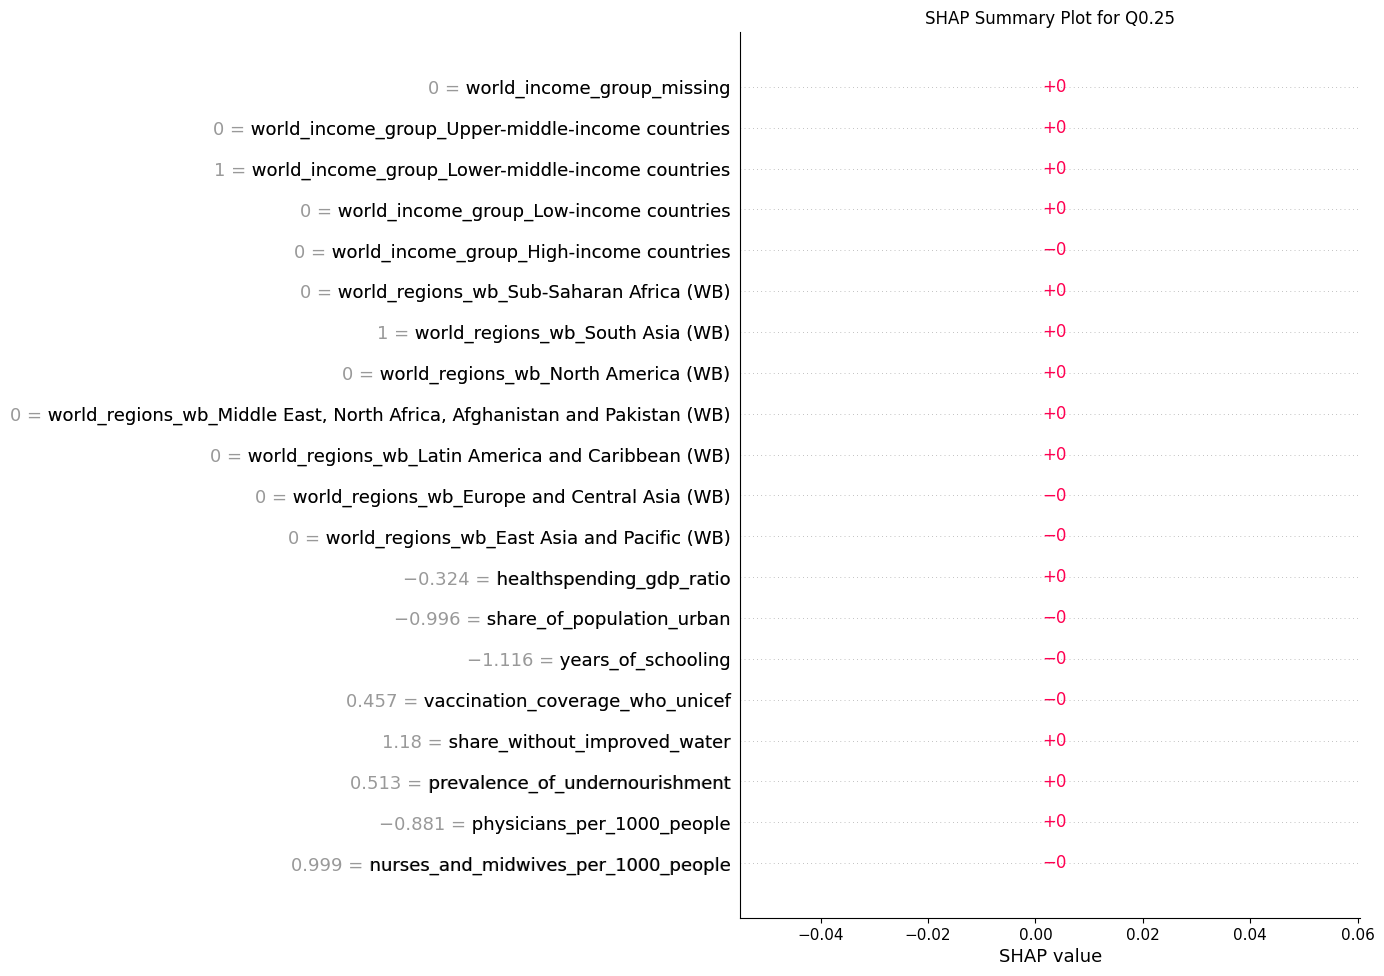

In [ ]:
for q, model in qr_models.items():
    qr_pipeline = model.regressor_
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    X_qr_transf = qr_pre.transform(bangladesh_df)
    X_qr_features = qr_pre.get_feature_names_out()

    expl = shap.Explainer(qr_model, X_qr_transf)
    shapvals = expl(X_qr_transf)
    shapvals.feature_names = list(X_qr_features)
    
    plt.title(f"SHAP Summary Plot for Q{q}")
    #shap.summary_plot(shapvals, X_qr_transf, feature_names=X_qr_features, rng=rng, plot_size=[15,6],  max_display=25)
    shap.plots.bar(shapvals[0], max_display=20) #first sample observation

    #shap.plots.waterfall(shap_vals[0])
    #shap.dependence_plot("share_without_improved_water", shapvals, X_qr_transf)
    plt.show()

#### Permutation Importance

In [122]:
pi_result_qr = permutation_importance(qr_models[0.75], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr.importances_mean, 4),
    'importance_std': np.round(pi_result_qr.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr

feature  importance_mean  importance_std
10                          world_regions_wb           0.2349          0.0309
8            vaccination_coverage_who_unicef           0.1229          0.0195
7               share_without_improved_water           0.0429          0.0113
9                         years_of_schooling           0.0408          0.0142
2                   gdp_per_capita_worldbank           0.0286          0.0049
6                  share_of_population_urban           0.0023          0.0032
11                        world_income_group           0.0019          0.0054
0                                     Entity           0.0000          0.0000
4                 physicians_per_1000_people          -0.0000          0.0007
1   annual_healthcare_expenditure_per_capita          -0.0019          0.0070
3        nurses_and_midwives_per_1000_people          -0.0102          0.0046
5             prevalence_of_undernourishment          -0.0145          0.0030

In [123]:
pi_result_qr5 = permutation_importance(qr_models[0.5], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr5 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr5.importances_mean, 4),
    'importance_std': np.round(pi_result_qr5.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr5

feature  importance_mean  importance_std
10                          world_regions_wb           0.2278          0.0251
7               share_without_improved_water           0.1229          0.0141
9                         years_of_schooling           0.1212          0.0167
8            vaccination_coverage_who_unicef           0.0939          0.0124
11                        world_income_group           0.0158          0.0029
3        nurses_and_midwives_per_1000_people           0.0089          0.0024
6                  share_of_population_urban           0.0082          0.0023
1   annual_healthcare_expenditure_per_capita           0.0018          0.0009
5             prevalence_of_undernourishment           0.0005          0.0026
2                   gdp_per_capita_worldbank           0.0003          0.0002
4                 physicians_per_1000_people           0.0002          0.0001
0                                     Entity           0.0000          0.0000

In [124]:
pi_result_qr25 = permutation_importance(qr_models[0.25], X_test, y_test, n_repeats=40, random_state=42)
importance_df_qr25 = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': np.round(pi_result_qr25.importances_mean, 4),
    'importance_std': np.round(pi_result_qr25.importances_std, 4)
}).sort_values(by='importance_mean', ascending=False)

importance_df_qr25

feature  importance_mean  importance_std
10                          world_regions_wb           0.1994          0.0212
7               share_without_improved_water           0.1579          0.0160
9                         years_of_schooling           0.1518          0.0180
8            vaccination_coverage_who_unicef           0.0716          0.0094
11                        world_income_group           0.0171          0.0025
1   annual_healthcare_expenditure_per_capita           0.0112          0.0016
5             prevalence_of_undernourishment           0.0080          0.0031
6                  share_of_population_urban           0.0050          0.0012
4                 physicians_per_1000_people           0.0042          0.0009
0                                     Entity           0.0000          0.0000
3        nurses_and_midwives_per_1000_people          -0.0000          0.0000
2                   gdp_per_capita_worldbank          -0.0063          0.0010

In [81]:
from joblib import dump

for q, model in qr_models.items():
    dump(model, f'best_model_quantile_{q}.joblib')

Koeffizienten für Q0.25
                                              Feature       Coef
14           world_regions_wb_Sub-Saharan Africa (WB)  16.544923
3                        share_without_improved_water   9.193005
16            world_income_group_Low-income countries   4.167749
2                      prevalence_of_undernourishment   2.642193
11  world_regions_wb_Middle East, North Africa, Af...   1.209456
17   world_income_group_Lower-middle-income countries   0.000000
0                 nurses_and_midwives_per_1000_people   0.000000
12                world_regions_wb_North America (WB)   0.000000
10  world_regions_wb_Latin America and Caribbean (WB)   0.000000
15           world_income_group_High-income countries   0.000000
13                   world_regions_wb_South Asia (WB)   0.000000
18   world_income_group_Upper-middle-income countries   0.000000
7                            healthspending_gdp_ratio  -0.191350
1                          physicians_per_1000_people  -0.507000
6

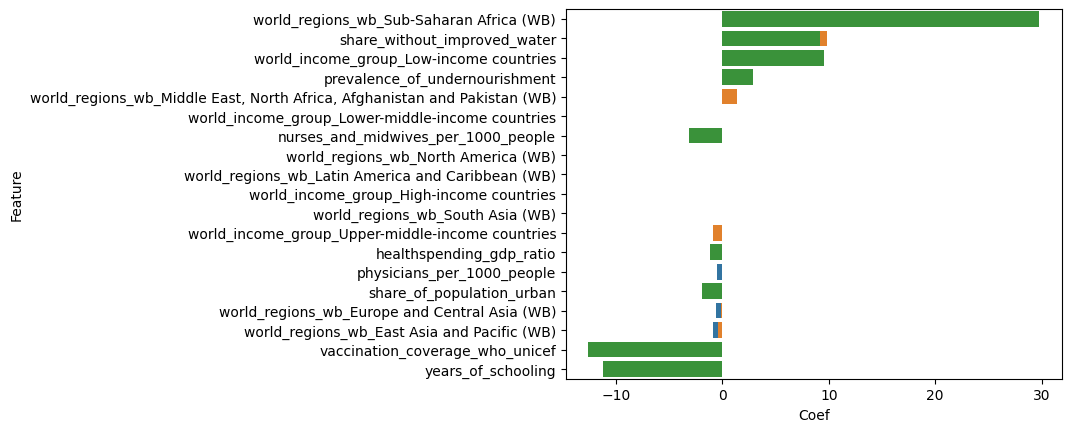

In [193]:
for q, model in qr_models.items():
    #qr_pipeline = model.regressor_
    qr_pipeline = model
    qr_pre = qr_pipeline.named_steps["preprocess"]
    qr_model = qr_pipeline.named_steps["model"]

    #X_qr_transf = qr_pre.transform(X_train)
    X_qr_features = qr_pre.get_feature_names_out()
    qr_coeffs = qr_model.coef_
    coefs_df = pd.DataFrame({"Feature": X_qr_features, "Coef": qr_coeffs}).sort_values(by="Coef", ascending=False)
    print(f"Koeffizienten für Q{q}")
    print(coefs_df)
    sns.barplot(coefs_df, x=coefs_df["Coef"], y=coefs_df["Feature"])